## Imports

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import datetime
warnings.filterwarnings('ignore')
#print(sns.__version__)

## Load Data
Note: Data obtained from various sources (via scraping with Beautiful Soup, manual entry) and compiled into .xlsx format prior to this workstream

In [2]:
#Read file into a DataFrame and print head.
xword_data = pd.ExcelFile('../data/NYT_XWord_data.xlsx', engine='openpyxl')
print(xword_data.sheet_names)

['Sheet1']


In [3]:
df1 = xword_data.parse('Sheet1')

In [ ]:
df1.head(35)

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Puzzle_Date                   2199 non-null   datetime64[ns]
 1   Completed_Date (IS1)          1155 non-null   datetime64[ns]
 2   Completed_Date (IS2)          1006 non-null   datetime64[ns]
 3   Day_of_Week                   2199 non-null   object        
 4   Time (s) (IS1)                1155 non-null   float64       
 5   Time (s) (IS2)                1006 non-null   float64       
 6   Global_Median_Solver_Time(s)  2199 non-null   int64         
 7   Difficulty                    2199 non-null   object        
 8   Median_Solver%_AVG_PM         2199 non-null   int64         
 9   Grid Size                     2199 non-null   int64         
 10  No_Constructors               2199 non-null   int64         
 11  Constructors(by seniority)    

## Data Cleaning and Global Median Solver (GMS) Feature Creation
A few generally useful operations for the GMS exploratory analysis

In [ ]:
# Delete weird columns at the back end of the imported data, if necessary
#df2 = df1.drop(columns=df1.columns[-6:], axis=1)

In [25]:
# Drop some columns that, while potentially useful for predictive modeling, aren't necessary for the EDA. Also drop columns specific to the individual solvers (IS1 and IS2), who will be analyzed in their own workstreams.
df2 = df1.drop(['Difficulty', '1st_Constructor', '1st_Constuctor_Gender', '1st_Constructor_Puzzle_N', '1st_Constructor_Debut', '1st_Constructor_Scrabble_Avg', '1st_Constructor_Fresh%_Avg', '2nd_Constructor', '2nd_Constuctor_Gender', '2nd_Constructor_Puzzle_N', '2nd_Constructor_Debut', '2nd_Constructor_Scrabble_Avg', '2nd_Constructor_Fresh%_Avg', '3rd_Constructor', '3rd_Constuctor_Gender', '3rd_Constructor_Puzzle_N', '3rd_Constructor_Debut', '3rd_Constructor_Scrabble_Avg', '3rd_Constructor_Fresh%_Avg', 'Spans', '2_Stacks', '3_4_Stacks', 'Mirror_Sym', 'UD_Sym', 'Asym', 'Supersym', '90_180_Rot_Sym', 'LR_UD_Sym', 'Diag_Sym', 'Black_Square_Fill','Outside_Grid', 'Unchecked_Sq','Uniclue','Duplicate_Answers','Quantum', 'Completed_Date (IS1)', 'Completed_Date (IS2)', 'Time (s) (IS1)', 'Time (s) (IS2)'], axis=1)

In [26]:
# It will be useful generally to have puzzle dates as strings in other columns along with the datetimes 
df2['P_Date_str'] = df2['Puzzle_Date'].dt.strftime('%Y-%m-%d') #we want datetime as a string to index into here

In [27]:
# Convert global median solve times per puzzle to minutes and drop times in seconds
df2["GMST(m)"] = df2["Global_Median_Solver_Time(s)"]/60  #GMST = Global Median solve times
df2.drop(['Global_Median_Solver_Time(s)'], axis=1, inplace=True)

In [28]:
# Calculate 10-puzzle moving average for global solver raw solve times, within Day of Week
# Unlike for Individual Solvers (see below), we do not have completion dates for median solver per puzzle. It is therefor assumed that completion date tracks with puzzle date (obviously not always going to be true, but approximates true closely enough for our purposes)
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = True)
df2['GMST(m)_10p_MA'] = df2.groupby('Day_of_Week')['GMST(m)'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = False)

In [29]:
# It will be useful to have year of puzzle issue in a separate column for analysis below
df2['P_Yr'] = df2['Puzzle_Date'].dt.to_period('Y')
df2['P_Yr'].value_counts()

2020    366
2023    365
2021    365
2019    365
2022    365
2018    365
2024      8
Freq: A-DEC, Name: P_Yr, dtype: int64

In [30]:
# Also, a column indicating pre-2023 puzzle issue date or 2023-2024 puzzle issue date
df2.loc[(df2["P_Yr"] != "2023") & (df2["P_Yr"] != "2024"), "2023+_puzzle"] = 0 #pre-2023 puzzle issue date
df2.loc[(df2["P_Yr"] == "2023") | (df2["P_Yr"] == "2024"), "2023+_puzzle"] = 1 #2023 or 2024 puzzle issue date

In [31]:
# Rename some columns for brevity and clarity
df2.rename(columns={'Constructors(by seniority)': 'Constructors', 'Median_Solver%_AVG_PM':'Diff%_from_10pMA(GMS)', 'Day_of_Week': 'DOW', 'Puzzle_Date': 'P_Date'}, inplace=True)

In [32]:
# A numerical column for puzzle day that starts with Sunday and ends with Saturday
df2.loc[(df2["DOW"] == "Sunday"), "DOW_num"] = 1 
df2.loc[(df2["DOW"] == "Monday"), "DOW_num"] = 2
df2.loc[(df2["DOW"] == "Tuesday"), "DOW_num"] = 3
df2.loc[(df2["DOW"] == "Wednesday"), "DOW_num"] = 4
df2.loc[(df2["DOW"] == "Thursday"), "DOW_num"] = 5
df2.loc[(df2["DOW"] == "Friday"), "DOW_num"] = 6
df2.loc[(df2["DOW"] == "Saturday"), "DOW_num"] = 7

In [33]:
# Move new columns to logical places in dataframe
col = df2.pop('P_Date_str')
df2.insert(1, col.name, col)

col = df2.pop('P_Yr')
df2.insert(2, col.name, col)

col = df2.pop('2023+_puzzle')
df2.insert(3, col.name, col)

col = df2.pop('DOW')
df2.insert(4, col.name, col)

col = df2.pop('DOW_num')
df2.insert(5, col.name, col)

col = df2.pop('GMST(m)')
df2.insert(6, col.name, col)

col = df2.pop('GMST(m)_10p_MA')
df2.insert(7, col.name, col)

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199 entries, 5 to 2194
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   P_Date                 2199 non-null   datetime64[ns]
 1   P_Date_str             2199 non-null   object        
 2   P_Yr                   2199 non-null   period[A-DEC] 
 3   2023+_puzzle           2199 non-null   float64       
 4   DOW                    2199 non-null   object        
 5   DOW_num                2199 non-null   float64       
 6   GMST(m)                2199 non-null   float64       
 7   GMST(m)_10p_MA         2185 non-null   float64       
 8   Diff%_from_10pMA(GMS)  2199 non-null   int64         
 9   Grid Size              2199 non-null   int64         
 10  No_Constructors        2199 non-null   int64         
 11  Constructors           2199 non-null   object        
 12  Words                  2199 non-null   int64         
 13  Blo

In [ ]:
# Checkpoint
# df2.to_csv('../data/df2.csv', index=False)

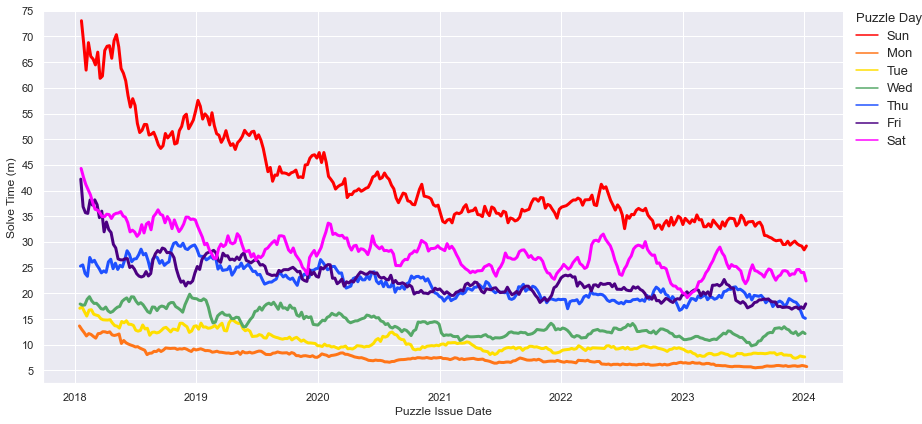

In [35]:
# Plot 10-puzzle moving average of Global Median Solve Times by Day of Week

sns.set(font_scale=1)

p = sns.relplot(
    data=df2, marker = "", x="P_Date", y="GMST(m)_10p_MA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=6, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3 
).set(title="", 
    ylabel="Solve Time (m)",
    xlabel= "Puzzle Issue Date", ylim=[2.5, 75], yticks = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
)

# Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.88, .975])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(13)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(13)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(13)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(13)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(13)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(13)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(13)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(13)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

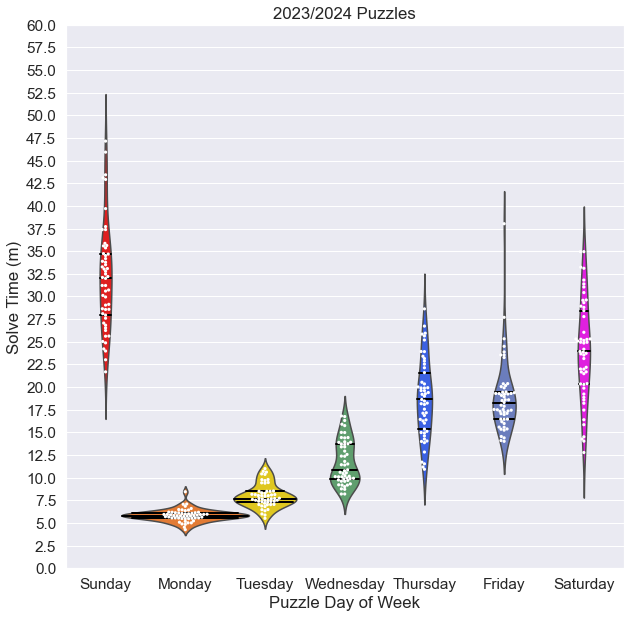

In [36]:
# Violin plots with swarm plot overlay by puzzle day -2023/4 only
#Note: Unlike with indvidual solver data, we do not have puzzle completion data for global median solver. 
#It is assumed therefore that puzzles were completed in the same sequence of puzzle issue (which is almost certainly approximately accurate at population level)
sns.set(font_scale=1.4)

GMS_2023 = df2.loc[df2["P_Date_str"].str.contains("2023") | df2["P_Date_str"].str.contains("2024")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2023 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2023['DOW'], GMS_2023['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 60)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60])
ax.set_title("2023/2024 Puzzles")
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

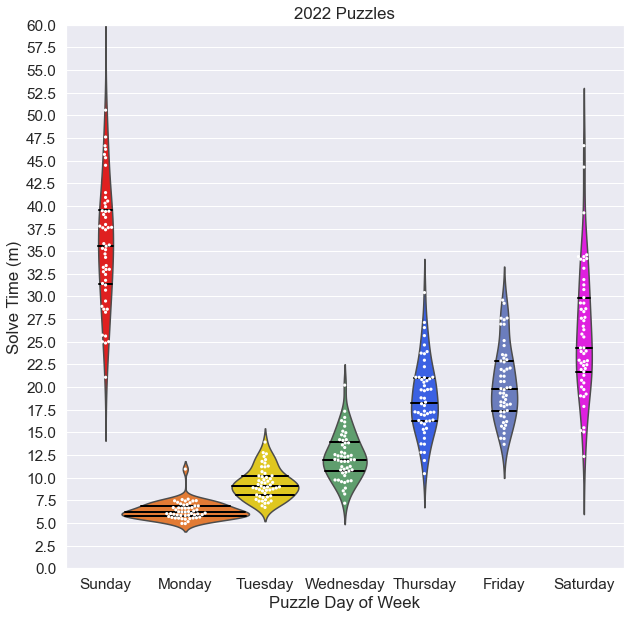

In [37]:
# Violin plots with swarm plot overlay by puzzle day -2022 only
#Note: Unlike with indvidual solver data, we do not have puzzle completion data for global median solver. 
#It is assumed therefore that puzzles were completed in the same sequence of puzzle issue (which is almost certainly approximately accurate at population level)
sns.set(font_scale=1.4)

GMS_2022 = df2.loc[df2["P_Date_str"].str.contains("2022")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2022 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2022['DOW'], GMS_2022['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 60)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5,60])
ax.set_title("2022 Puzzles")
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

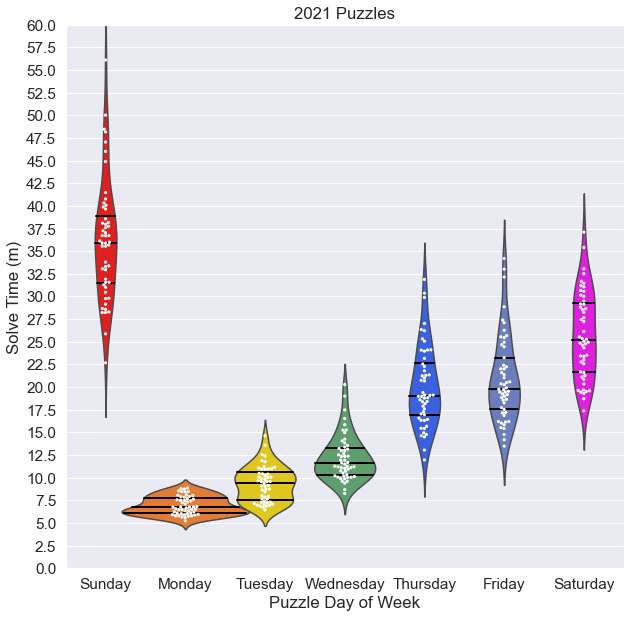

In [38]:
# Violin plots with swarm plot overlay by puzzle day -2021 only
#Note: Unlike with indvidual solver data, we do not have puzzle completion data for global median solver. 
#It is assumed therefore that puzzles were completed in the same sequence of puzzle issue (which is almost certainly approximately accurate at population level)
sns.set(font_scale=1.4)

GMS_2021 = df2.loc[df2["P_Date_str"].str.contains("2021")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2021 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2021['DOW'], GMS_2021['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 60)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60])
ax.set_title("2021 Puzzles")
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

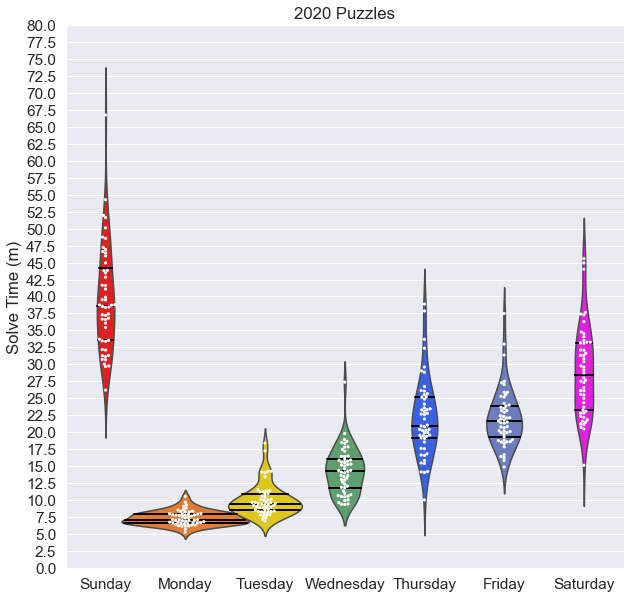

In [39]:
# Violin plots with swarm plot overlay by puzzle day -2020 only
#Note: Unlike with indvidual solver data, we do not have puzzle completion data for global median solver. 
#It is assumed therefore that puzzles were completed in the same sequence of puzzle issue (which is almost certainly approximately accurate at population level)
sns.set(font_scale=1.4)

GMS_2020 = df2.loc[df2["P_Date_str"].str.contains("2020")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2020 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2020['DOW'], GMS_2020['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 80)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5,65,67.5,70,72.5,75,77.5,80])
ax.set_title("2020 Puzzles")
ax.set_xlabel("")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

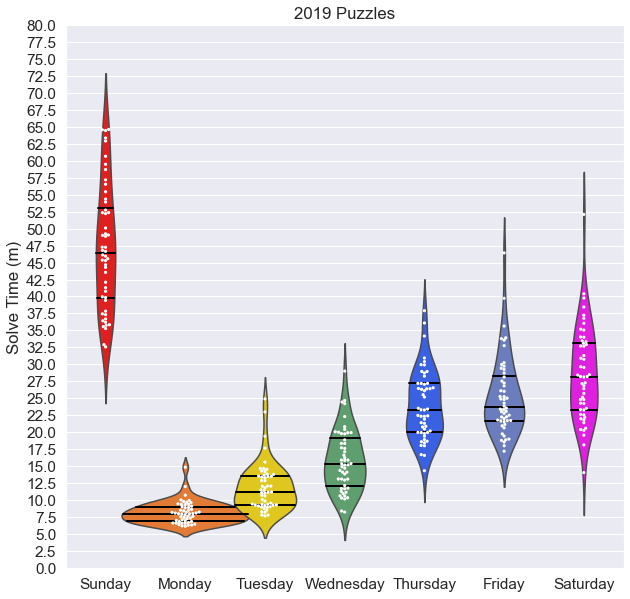

In [40]:
# Violin plots with swarm plot overlay by puzzle day 2019 solves only

GMS_2019 = df2.loc[df2["P_Date_str"].str.contains("2019")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2019 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2019['DOW'], GMS_2019['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 60)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75, 77.5, 80])
ax.set_title("2019 Puzzles")
ax.set_xlabel("")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

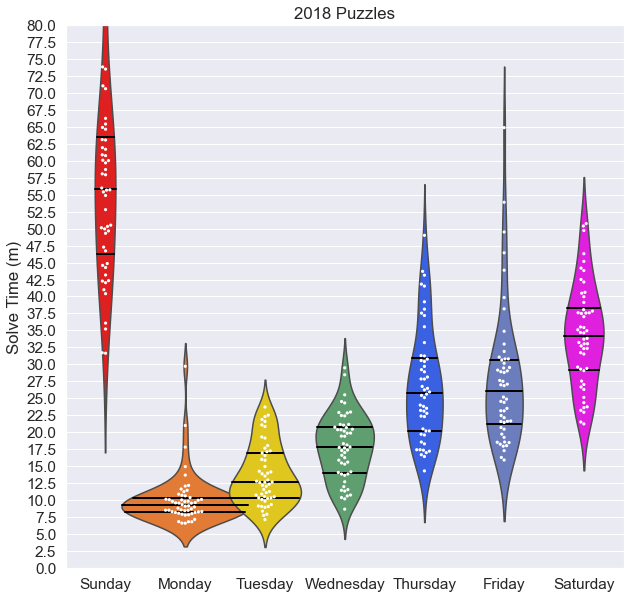

In [41]:
# Violin plots with swarm plot overlay by puzzle day 2018 solves only

GMS_2018 = df2.loc[df2["P_Date_str"].str.contains("2018")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2018 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2018['DOW'], GMS_2018['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 80)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75, 77.5, 80])
ax.set_title("2018 Puzzles")
ax.set_xlabel("")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [43]:
# Calculate Median and IQR per puzzle day, per puzzle year (2023/2024 only here)
print(GMS_2023.loc[(GMS_2023["DOW"] == "Sunday"), "GMST(m)"].describe().round(1))
print(GMS_2023.loc[(GMS_2023["DOW"] == "Monday"), "GMST(m)"].describe().round(1))
print(GMS_2023.loc[(GMS_2023["DOW"] == "Tuesday"), "GMST(m)"].describe().round(1))
print(GMS_2023.loc[(GMS_2023["DOW"] == "Wednesday"), "GMST(m)"].describe().round(1))
print(GMS_2023.loc[(GMS_2023["DOW"] == "Thursday"), "GMST(m)"].describe().round(1))
print(GMS_2023.loc[(GMS_2023["DOW"] == "Friday"), "GMST(m)"].describe().round(1))
print(GMS_2023.loc[(GMS_2023["DOW"] == "Saturday"), "GMST(m)"].describe().round(1))

count    54.0
mean     32.0
std       5.8
min      21.7
25%      28.0
50%      32.0
75%      34.7
max      47.2
Name: GMST(m), dtype: float64
count    54.0
mean      5.8
std       0.7
min       4.3
25%       5.6
50%       5.8
75%       6.1
max       8.4
Name: GMST(m), dtype: float64
count    53.0
mean      8.0
std       1.3
min       5.5
25%       7.3
50%       7.7
75%       8.5
max      11.0
Name: GMST(m), dtype: float64
count    53.0
mean     11.8
std       2.4
min       8.2
25%       9.9
50%      10.9
75%      13.8
max      16.8
Name: GMST(m), dtype: float64
count    53.0
mean     18.7
std       4.3
min      10.9
25%      15.4
50%      18.6
75%      21.6
max      28.6
Name: GMST(m), dtype: float64
count    53.0
mean     18.9
std       4.0
min      14.0
25%      16.5
50%      18.3
75%      19.5
max      38.0
Name: GMST(m), dtype: float64
count    53.0
mean     24.0
std       5.5
min      12.8
25%      20.4
50%      23.9
75%      28.4
max      35.0
Name: GMST(m), dtype: float64


### Constructor Analysis
Which constructors does the global median solver struggle against? Which ones does the global median solver do well against? This analysis is with respect to average deviation from day-specific 10-puzzle moving average per constructor/constructor team. 

In [44]:
# Make a deep copy of df2
df_GMS = df2.copy()

In [45]:
#Get by-constructor performance stats for Global Median Solver
constructor_avgs_GMS = df_GMS.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].agg(constructor_mean_GMS=(np.mean), puzzle_count_GMS=(np.count_nonzero))
constructor_avgs_GMS["constructor_mean_GMS"] = constructor_avgs_GMS["constructor_mean_GMS"].round(2)

puzzle_min_threshold = 5 #min number of puzzles in sample for constructor/constructor team to be kept in the analysis 

# Pare down to only constructor(s) with at least n puzzles for which IS1 has completed
constructor_avgs_filter = constructor_avgs_GMS.loc[constructor_avgs_GMS['puzzle_count_GMS'] >= puzzle_min_threshold] 

In [ ]:
#constructor_avgs_filter.to_csv('../data/constructor_avgs_filter.csv', index=True)

In [46]:
constructor_avgs_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115 entries, Adam Aaronson to Zhouqin Burnikel
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   constructor_mean_GMS  115 non-null    float64
 1   puzzle_count_GMS      115 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 2.7+ KB


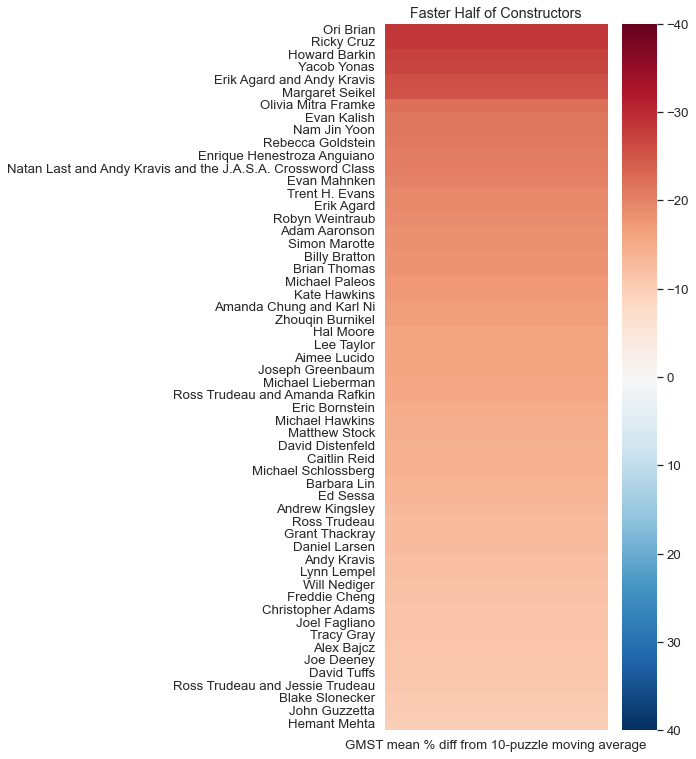

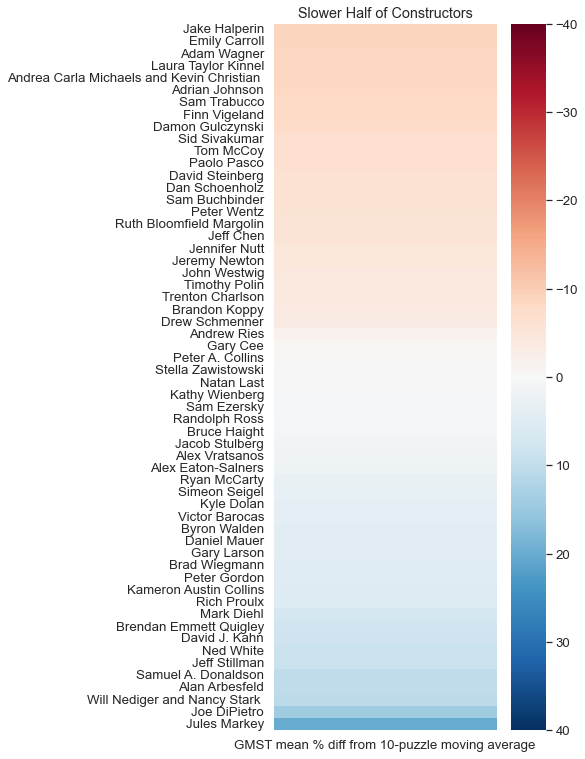

In [47]:
# Construct Heat Map sorted by fastest constructor relative to GMS 10 puzzle moving average to slowest

#Remove puzzle ns columns and sort for heatmapping
avgs = constructor_avgs_filter[["constructor_mean_GMS"]]
avgs = avgs.sort_values(by=['constructor_mean_GMS'], ascending = True)

first_half_end = int((len(avgs)/2)-1)
avgs_end = int(len(avgs))
first_half = avgs[0:first_half_end]
second_half = avgs[(first_half_end+1):avgs_end]

first_half = first_half.sort_values(by=['constructor_mean_GMS'], ascending = True)
plt.figure(figsize=(5,13))
sns.set(font_scale=1.2)
ax = sns.heatmap(first_half, xticklabels=['GMST mean % diff from 10-puzzle moving average'], cmap="RdBu", vmin=-40, vmax=40, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
plt.ylabel('')
plt.title("Faster Half of Constructors")
plt.show()

second_half = second_half.sort_values(by=['constructor_mean_GMS'], ascending = True)
plt.figure(figsize=(5,13))
sns.set(font_scale=1.2)
ax2 = sns.heatmap(second_half, xticklabels=['GMST mean % diff from 10-puzzle moving average'], cmap="RdBu",vmin=-40, vmax=40, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
plt.ylabel('')
plt.title("Slower Half of Constructors")
plt.show()

In [48]:
constructor_avgs_filter[["constructor_mean_GMS"]].agg(['min', 'max'])

constructor_mean_GMS
min                -28.57
max                 20.00

In [49]:
# Calculate past performance against a given constructor (% difference from 10-puzzle moving average) for each puzzle in sample
# Global Median Solver mean past performance versus a given constructor(s), per puzzle. 
# This is calculated off of deviation from 10-puzzle moving average, so that it can be collapsed across puzzle days
# Getting the count as well will allow filtering by past number of puzzles for a second version of the figure

df_GMS = df_GMS.sort_values(by=['Constructors','P_Date'], ascending = False)

df_GMS = df_GMS.iloc[::-1]
df_GMS['GMS_per_constr_avg_past_diff_from_10pMA'] = df_GMS.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].transform(lambda x: x.rolling(window=100, min_periods = 1).mean().round(2).shift(1))
df_GMS['GMS_per_constr_past_diff_from_10pMA_ct'] = df_GMS.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].transform(lambda x: x.rolling(window=100, min_periods = 1).count().shift(1))
df_GMS = df_GMS.iloc[::-1]

# col = df_GMS.pop('GMS_per_constr_avg_past_diff_from_10pMA')
# df_GMS.insert(17, col.name, col)

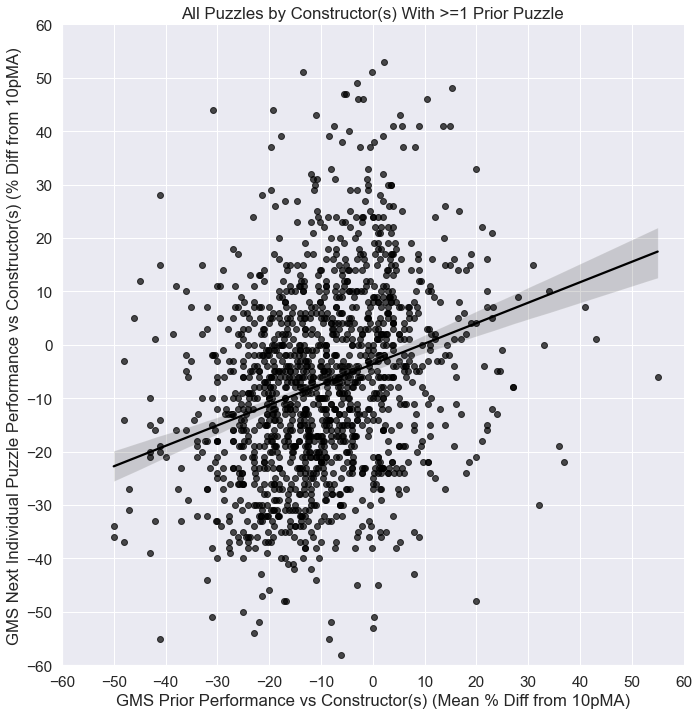

In [50]:
#Plot GMS_per_constr_avg_past_diff_from_10pMA vs diff%_from_10pMA(GMS) for all puzzles 
# Idea here is to get correlation between past performance vs a given constructor and performance on a given puzzle, in a way that is normalized for both puzzle day difficulty and recent past performance

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS, x="GMS_per_constr_avg_past_diff_from_10pMA", y="Diff%_from_10pMA(GMS)",
    height=10, aspect=1, legend=False, scatter_kws = {"color": "black", "alpha": 0.7}, line_kws = {"color": "black"}
).set(title="All Puzzles by Constructor(s) With >=1 Prior Puzzle", xlabel= "GMS Prior Performance vs Constructor(s) (Mean % Diff from 10pMA)",
    ylabel="GMS Next Individual Puzzle Performance vs Constructor(s) (% Diff from 10pMA)", xticks =[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60], yticks =[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60]
)

# #Adjust subplots individually
_= p.set(ylim=(-60, 60))
_= p.set(xlim=(-60, 60))

In [51]:
# Correlation Calculation (Pearson r)
print(df_GMS['Diff%_from_10pMA(GMS)'].corr(df_GMS['GMS_per_constr_avg_past_diff_from_10pMA']))

0.27706238669209


In [52]:
# Create df that includes only puzzles with Constructor(s) where there are >=4 prior puzzles by them
df_GMS_filter = df_GMS.loc[(df_GMS["GMS_per_constr_past_diff_from_10pMA_ct"] >= 4)]
df_GMS_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747 entries, 706 to 742
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   P_Date                                   747 non-null    datetime64[ns]
 1   P_Date_str                               747 non-null    object        
 2   P_Yr                                     747 non-null    period[A-DEC] 
 3   2023+_puzzle                             747 non-null    float64       
 4   DOW                                      747 non-null    object        
 5   DOW_num                                  747 non-null    float64       
 6   GMST(m)                                  747 non-null    float64       
 7   GMST(m)_10p_MA                           747 non-null    float64       
 8   Diff%_from_10pMA(GMS)                    747 non-null    int64         
 9   Grid Size                                

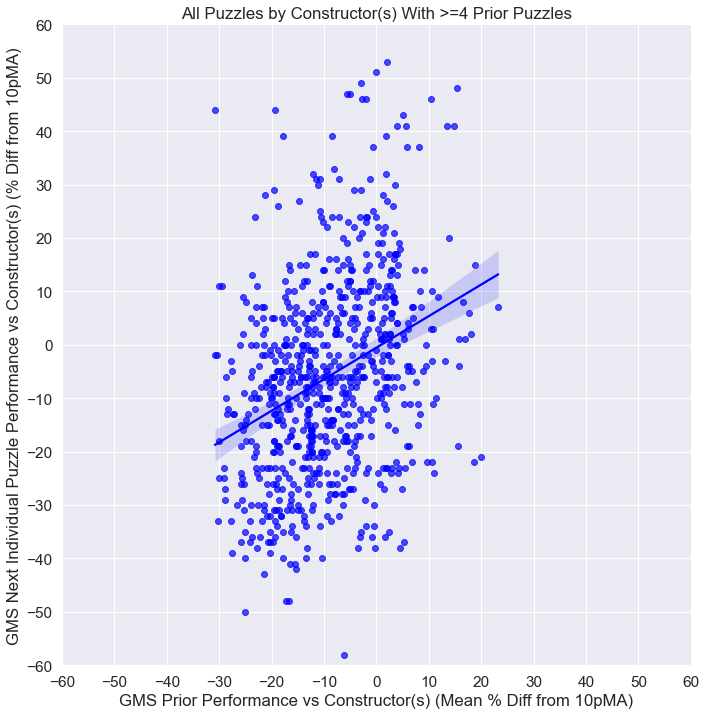

In [53]:
#Plot GMS_per_constr_avg_past_diff_from_10pMA vs diff%_from_10pMA(GMS) for all puzzles whose constructor had at least 4 prior puzzles in the sample
# Idea here is to get correlation between past performance vs a given constructor and performance on a given puzzle, in a way that is normalized for both puzzle day difficulty and recent past performance

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS_filter, x="GMS_per_constr_avg_past_diff_from_10pMA", y="Diff%_from_10pMA(GMS)",
    height=10, aspect=1, legend=False, scatter_kws = {"color": "blue", "alpha": 0.7}, line_kws = {"color": "blue"}
).set(title="All Puzzles by Constructor(s) With >=4 Prior Puzzles", xlabel= "GMS Prior Performance vs Constructor(s) (Mean % Diff from 10pMA)",
    ylabel="GMS Next Individual Puzzle Performance vs Constructor(s) (% Diff from 10pMA)", xticks =[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60], yticks =[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60]
)

# #Adjust subplots individually
_= p.set(ylim=(-60, 60))
_= p.set(xlim=(-60, 60))

In [54]:
# Correlation Calculation (Pearson R)
print(df_GMS_filter['Diff%_from_10pMA(GMS)'].corr(df_GMS['GMS_per_constr_avg_past_diff_from_10pMA']))

0.3233587898982648


### Puzzle and Answer-Features Correlation to Solve Times

Create a few new features for day-specific weighted global median solver solver past performance to use as frame of reference for the puzzle and answer-specific correlations

In [55]:
#GMS_pds_l10_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the global median solver over the previous 10 puzzles

df_GMS = df_GMS.sort_values(by=['DOW', 'P_Date'], ascending = False)

w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

df_GMS["GMS_pds_l10_dw_1"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
df_GMS["GMS_pds_l10_dw_2"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
df_GMS["GMS_pds_l10_dw_3"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
df_GMS["GMS_pds_l10_dw_4"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
df_GMS["GMS_pds_l10_dw_5"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
df_GMS["GMS_pds_l10_dw_6"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
df_GMS["GMS_pds_l10_dw_7"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
df_GMS["GMS_pds_l10_dw_8"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
df_GMS["GMS_pds_l10_dw_9"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
df_GMS["GMS_pds_l10_dw_10"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]

df_GMS["GMS_pds_l10_dw_1_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
df_GMS["GMS_pds_l10_dw_2_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
df_GMS["GMS_pds_l10_dw_3_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
df_GMS["GMS_pds_l10_dw_4_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
df_GMS["GMS_pds_l10_dw_5_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
df_GMS["GMS_pds_l10_dw_6_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
df_GMS["GMS_pds_l10_dw_7_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
df_GMS["GMS_pds_l10_dw_8_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
df_GMS["GMS_pds_l10_dw_9_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
df_GMS["GMS_pds_l10_dw_10_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]

df_GMS["GMS_pds_l10_ws"] = df_GMS[["GMS_pds_l10_dw_1", "GMS_pds_l10_dw_2", "GMS_pds_l10_dw_3", "GMS_pds_l10_dw_4", "GMS_pds_l10_dw_5", "GMS_pds_l10_dw_6", "GMS_pds_l10_dw_7", "GMS_pds_l10_dw_8", "GMS_pds_l10_dw_9", "GMS_pds_l10_dw_10"]].sum(axis=1)
df_GMS["GMS_pds_l10_ws_ct"] = df_GMS[["GMS_pds_l10_dw_1_ct", "GMS_pds_l10_dw_2_ct", "GMS_pds_l10_dw_3_ct", "GMS_pds_l10_dw_4_ct", "GMS_pds_l10_dw_5_ct", "GMS_pds_l10_dw_6_ct", "GMS_pds_l10_dw_7_ct", "GMS_pds_l10_dw_8_ct", "GMS_pds_l10_dw_9_ct", "GMS_pds_l10_dw_10_ct"]].sum(axis=1)
df_GMS["GMS_pds_l10_dw"] = df_GMS["GMS_pds_l10_ws"]/df_GMS["GMS_pds_l10_ws_ct"]

# Deleting transient columns
df_GMS = df_GMS.drop(["GMS_pds_l10_dw_1", "GMS_pds_l10_dw_2", "GMS_pds_l10_dw_3", "GMS_pds_l10_dw_4", "GMS_pds_l10_dw_5", "GMS_pds_l10_dw_6", "GMS_pds_l10_dw_7", "GMS_pds_l10_dw_8", "GMS_pds_l10_dw_9", "GMS_pds_l10_dw_10", "GMS_pds_l10_dw_1_ct", "GMS_pds_l10_dw_2_ct", "GMS_pds_l10_dw_3_ct", "GMS_pds_l10_dw_4_ct", "GMS_pds_l10_dw_5_ct", "GMS_pds_l10_dw_6_ct", "GMS_pds_l10_dw_7_ct", "GMS_pds_l10_dw_8_ct", "GMS_pds_l10_dw_9_ct", "GMS_pds_l10_dw_10_ct", "GMS_pds_l10_ws", "GMS_pds_l10_ws_ct"], axis = 1)

In [59]:
df_GMS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199 entries, 5 to 2194
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   P_Date                                   2199 non-null   datetime64[ns]
 1   P_Date_str                               2199 non-null   object        
 2   P_Yr                                     2199 non-null   period[A-DEC] 
 3   2023+_puzzle                             2199 non-null   float64       
 4   DOW                                      2199 non-null   object        
 5   DOW_num                                  2199 non-null   float64       
 6   GMST(m)                                  2199 non-null   float64       
 7   GMST(m)_10p_MA                           2185 non-null   float64       
 8   Diff%_from_10pMA(GMS)                    2199 non-null   int64         
 9   GMS_pds_l10_dw                           

In [58]:
# Move new columns to logical places in dataframe
col = df_GMS.pop('GMS_pds_l10_dw')
df_GMS.insert(9, col.name, col)

col = df_GMS.pop('GMS_per_constr_avg_past_diff_from_10pMA')
df_GMS.insert(10, col.name, col)

col = df_GMS.pop('GMS_per_constr_past_diff_from_10pMA_ct')
df_GMS.insert(11, col.name, col)

#And one puzzle feature to a more logical place
col = df_GMS.pop('Open_Squares')
df_GMS.insert(13, col.name, col)

In [ ]:
# Global Median Solver mean past performance versus a given constructor(s), per puzzle. 
# This is calculated off of deviation from 10-puzzle moving average, so that it can be collapsed across puzzle days

# df_GMS = df_GMS.sort_values(by=['Constructors','P_Date'], ascending = False)

# df_GMS = df_GMS.iloc[::-1]
# df_GMS['GMS_per_constr_avg_past_diff_from_10pMA'] = df_GMS.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].transform(lambda x: x.rolling(window=100, min_periods = 1).mean().round(2).shift(1))
# df_GMS = df_GMS.iloc[::-1]

# col = df_GMS.pop('GMS_per_constr_avg_past_diff_from_10pMA')
# df_GMS.insert(17, col.name, col)

In [ ]:
df_GMS.to_csv('../data/df_GMS.csv', index=False)

### Correlation of Puzzle and Answer Feature Parameters to Individual GMS Puzzle Solve Times 

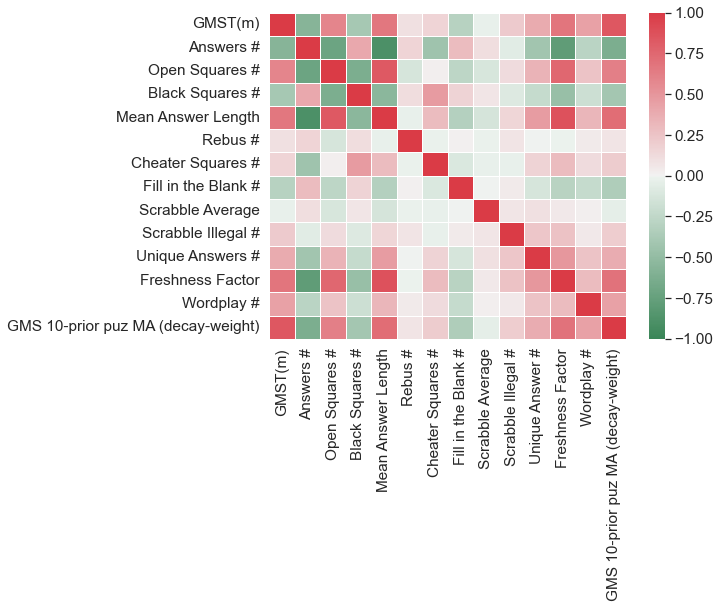

In [60]:
# 15x15 Puzzles Features Correlation to Global Median Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "GMS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Mean Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)',    
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Mean Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'GMS 10-prior puz MA (decay-weight)'])
#_= ans.set_yticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Recent Adj Perf', 'Past Perf vs Constructor(s)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

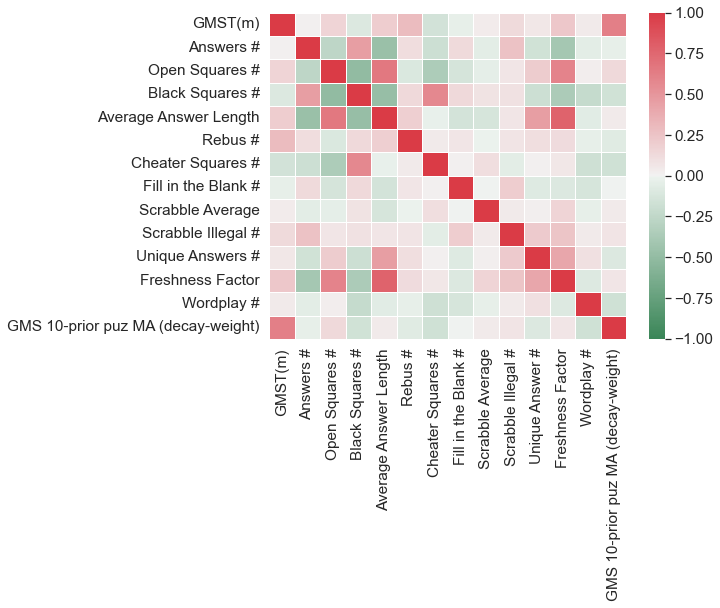

In [61]:
# 21x21 (Sunday) Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_21x21 = df_GMS.loc[df_GMS["DOW"]==("Sunday")]
puzzle_features = GMS_21x21[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "GMS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)'    
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'GMS 10-prior puz MA (decay-weight)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

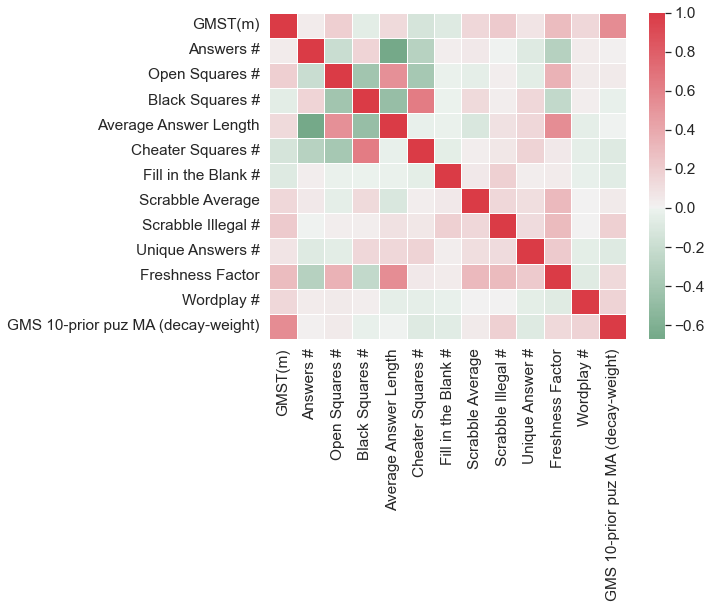

In [62]:
# Monday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Monday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "GMS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',     
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'GMS 10-prior puz MA (decay-weight)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

In [ ]:
df_GMS_Mon.info()

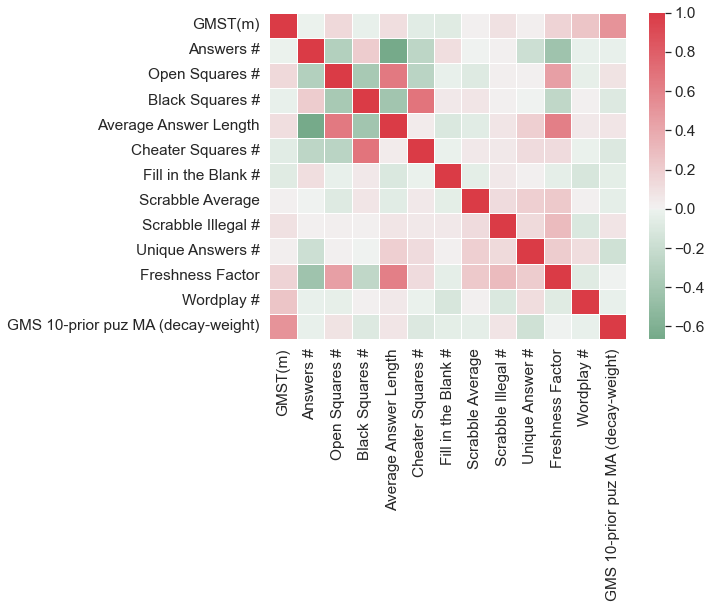

In [63]:
# Tuesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Tuesday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "GMS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',     
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'GMS 10-prior puz MA (decay-weight)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

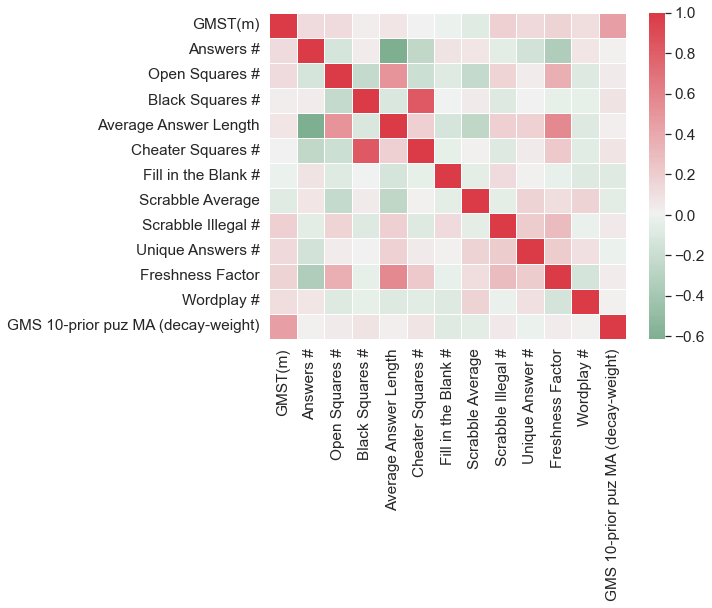

In [64]:
# Wednesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Wednesday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "GMS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',     
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'GMS 10-prior puz MA (decay-weight)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

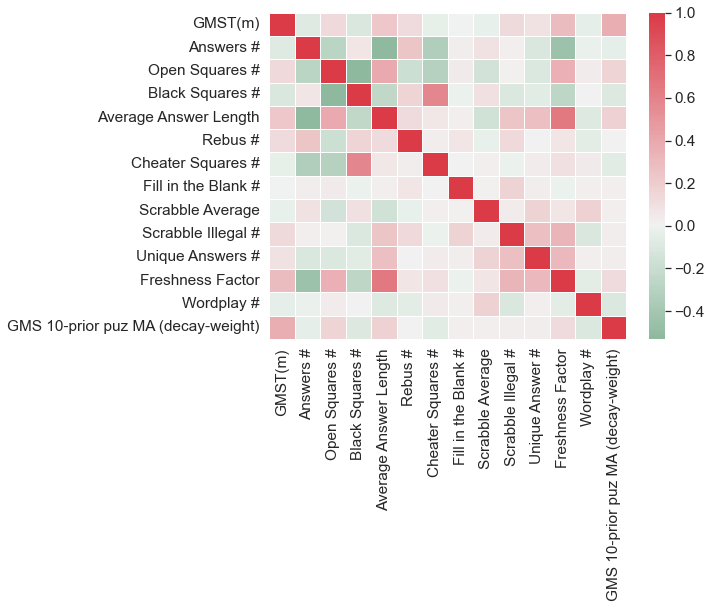

In [65]:
# Thursday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Thursday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "GMS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'GMS 10-prior puz MA (decay-weight)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

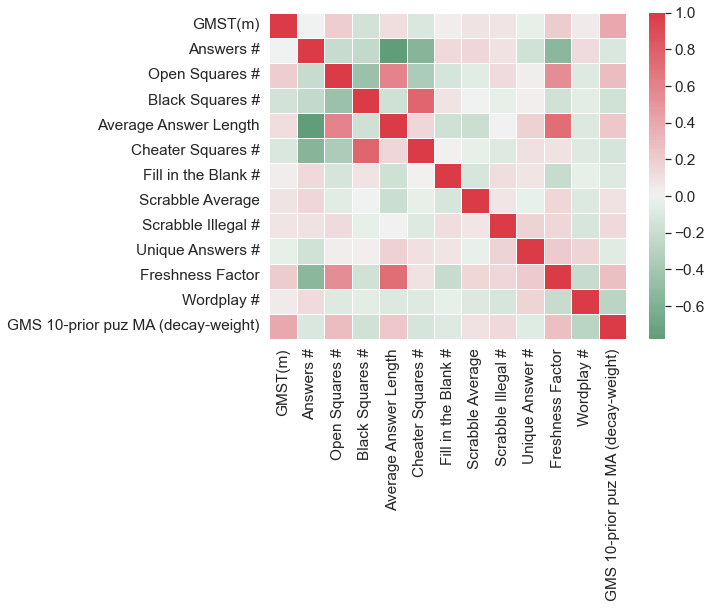

In [66]:
# Friday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Friday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "GMS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',     
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'GMS 10-prior puz MA (decay-weight)'])

#save image 
# figure = ans.get_figure()    

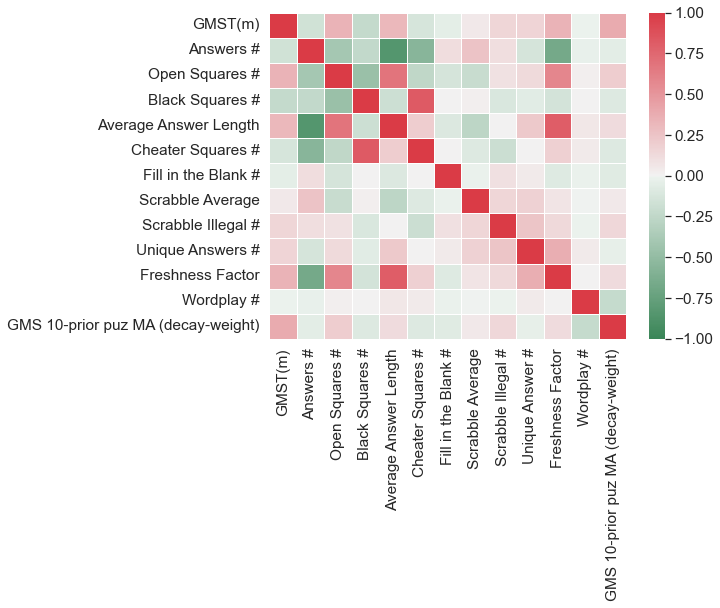

In [67]:
# Saturday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Saturday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "GMS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',     
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay': 'Wordplay #',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'GMS 10-prior puz MA (decay-weight)'])

#save image 
# figure = ans.get_figure()    

### Scatterplots of Relationship of Grid and Answer Parameters to GMS Performance

In [ ]:
df_GMS.info()

In [68]:
# Create new df with all rows copied and placed below current rows. 
# This is so we can plot all 15x15 data together as a subplot in the figures below

df_GMS_copy = df_GMS.loc[(df_GMS["DOW_num"] != 1)] #15x15 only
df_GMS_copy["DOW_num"] = 0

df_GMS2 = pd.concat([df_GMS, df_GMS_copy],ignore_index=True)

In [ ]:
df_GMS2.info()

In [ ]:
df_GMS2["DOW_num"].unique()

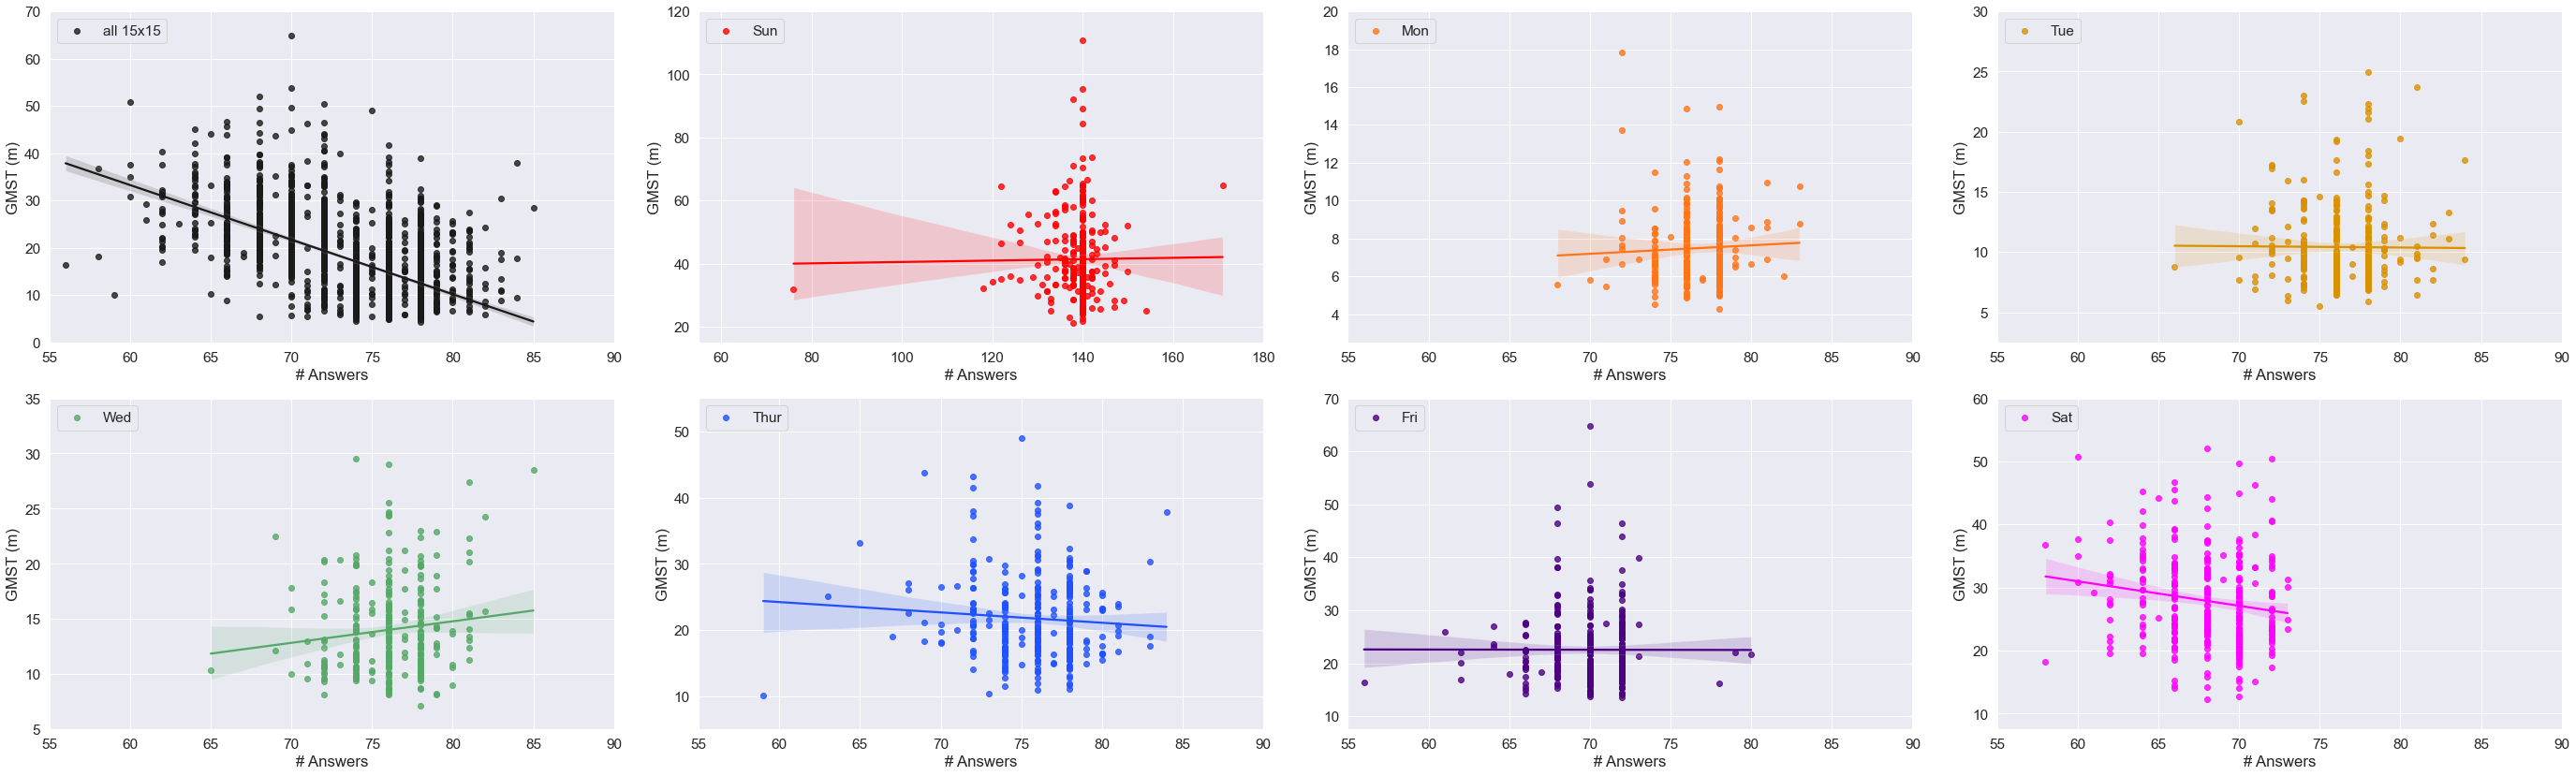

In [69]:
# Number of Answers vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Words", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Answers",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((55,90))
p.axes[1].set_xlim((55,180))
p.axes[2].set_xlim((55,90))
p.axes[3].set_xlim((55,90))
p.axes[4].set_xlim((55,90))
p.axes[5].set_xlim((55,90))
p.axes[6].set_xlim((55,90))
p.axes[7].set_xlim((55,90))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [70]:
# Calculate Pearson R for 15x15 grids for this feature
GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Words']))

-0.5628763148379492


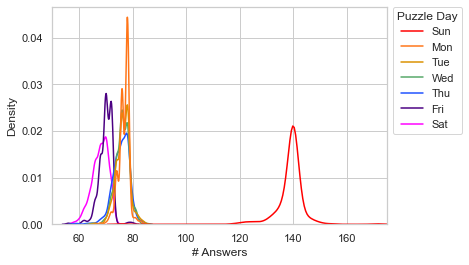

In [71]:
# Density plot of number of answers in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together
df_GMS['plot_seq_map'] = df_GMS['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Words", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(50, 175)
ax.set_xlabel("# Answers")
plt.show()

In [72]:
df_GMS["Words"].agg(['min', 'max'])

min     56
max    171
Name: Words, dtype: int64

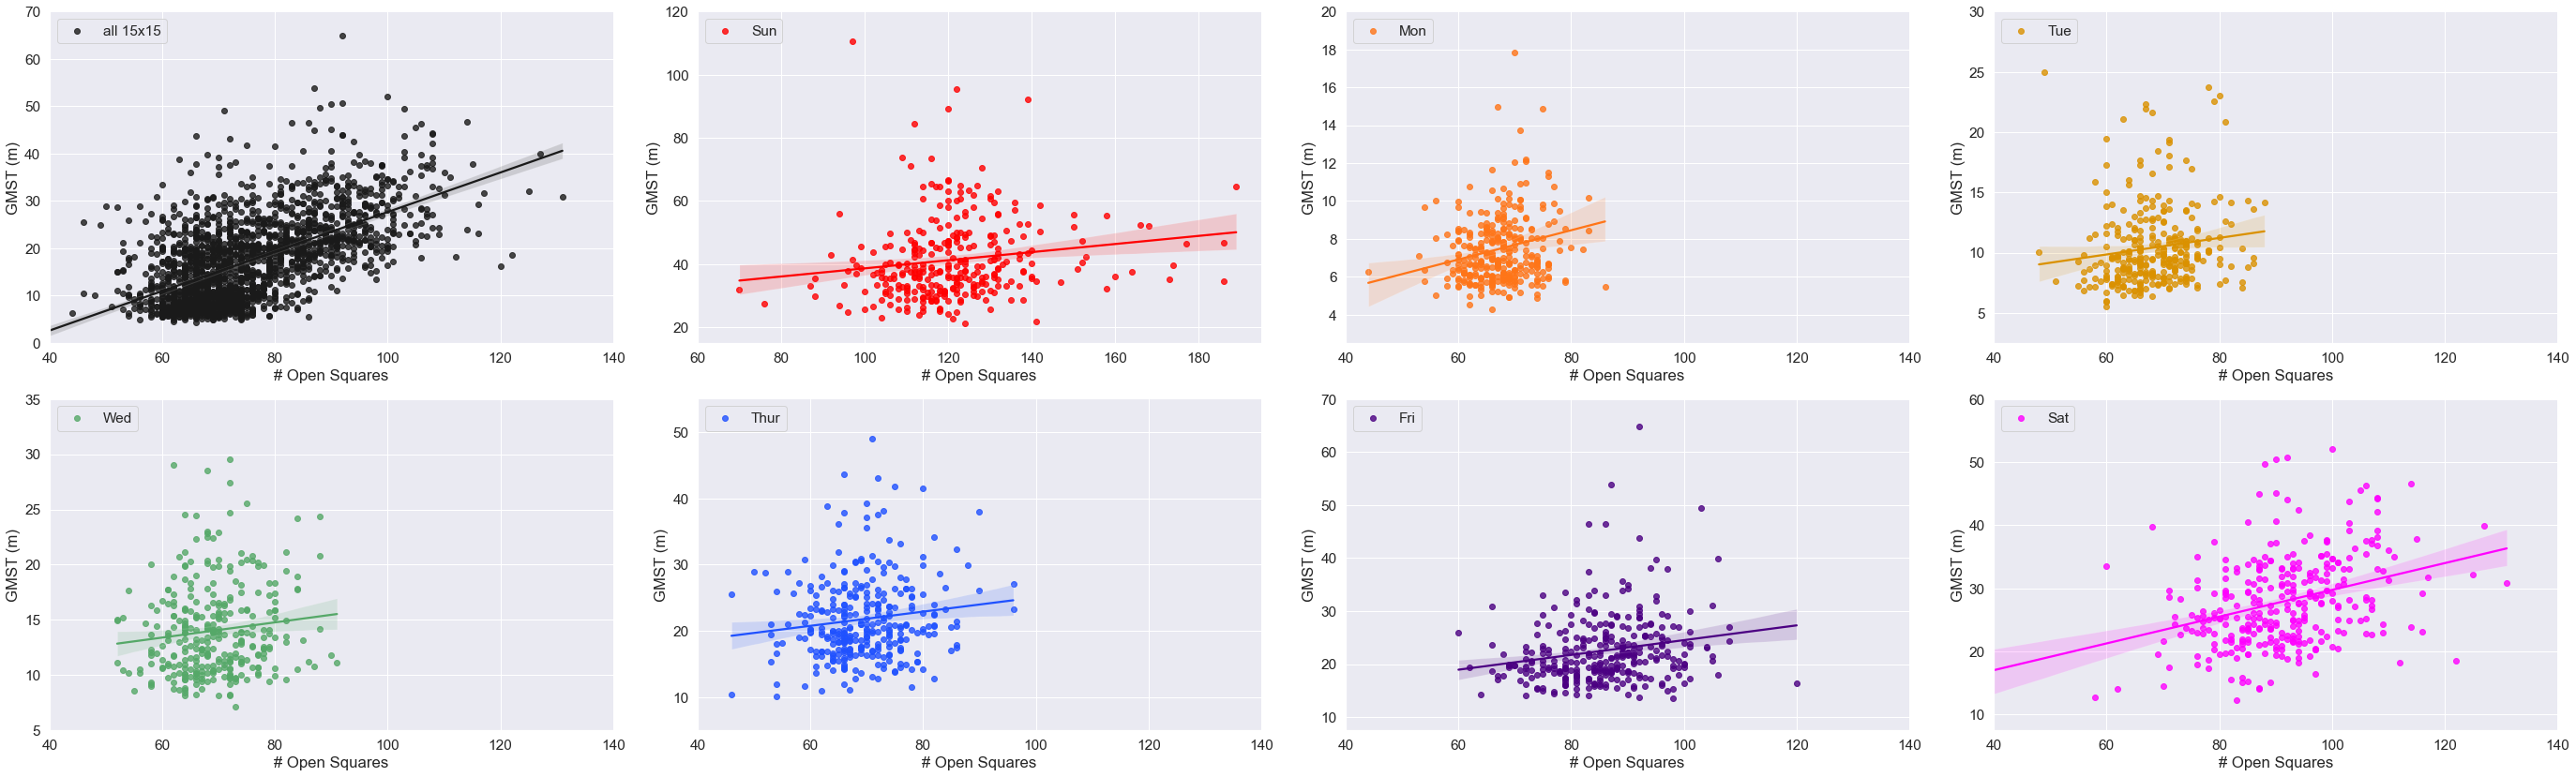

In [73]:
# Open Squares vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Open_Squares", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Open Squares",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((40,140))
p.axes[1].set_xlim((60,195))
p.axes[2].set_xlim((40,140))
p.axes[3].set_xlim((40,140))
p.axes[4].set_xlim((40,140))
p.axes[5].set_xlim((40,140))
p.axes[6].set_xlim((40,140))
p.axes[7].set_xlim((40,140))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [74]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Open_Squares']))

0.5883330927257643


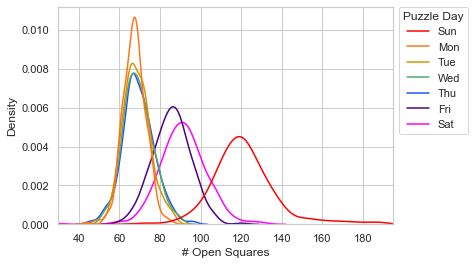

In [75]:
# Density plot of number of open squares in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Open_Squares", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(30, 195)
ax.set_xlabel("# Open Squares")
plt.show()

In [76]:
df_GMS["Open_Squares"].agg(['min', 'max'])

min     29
max    189
Name: Open_Squares, dtype: int64

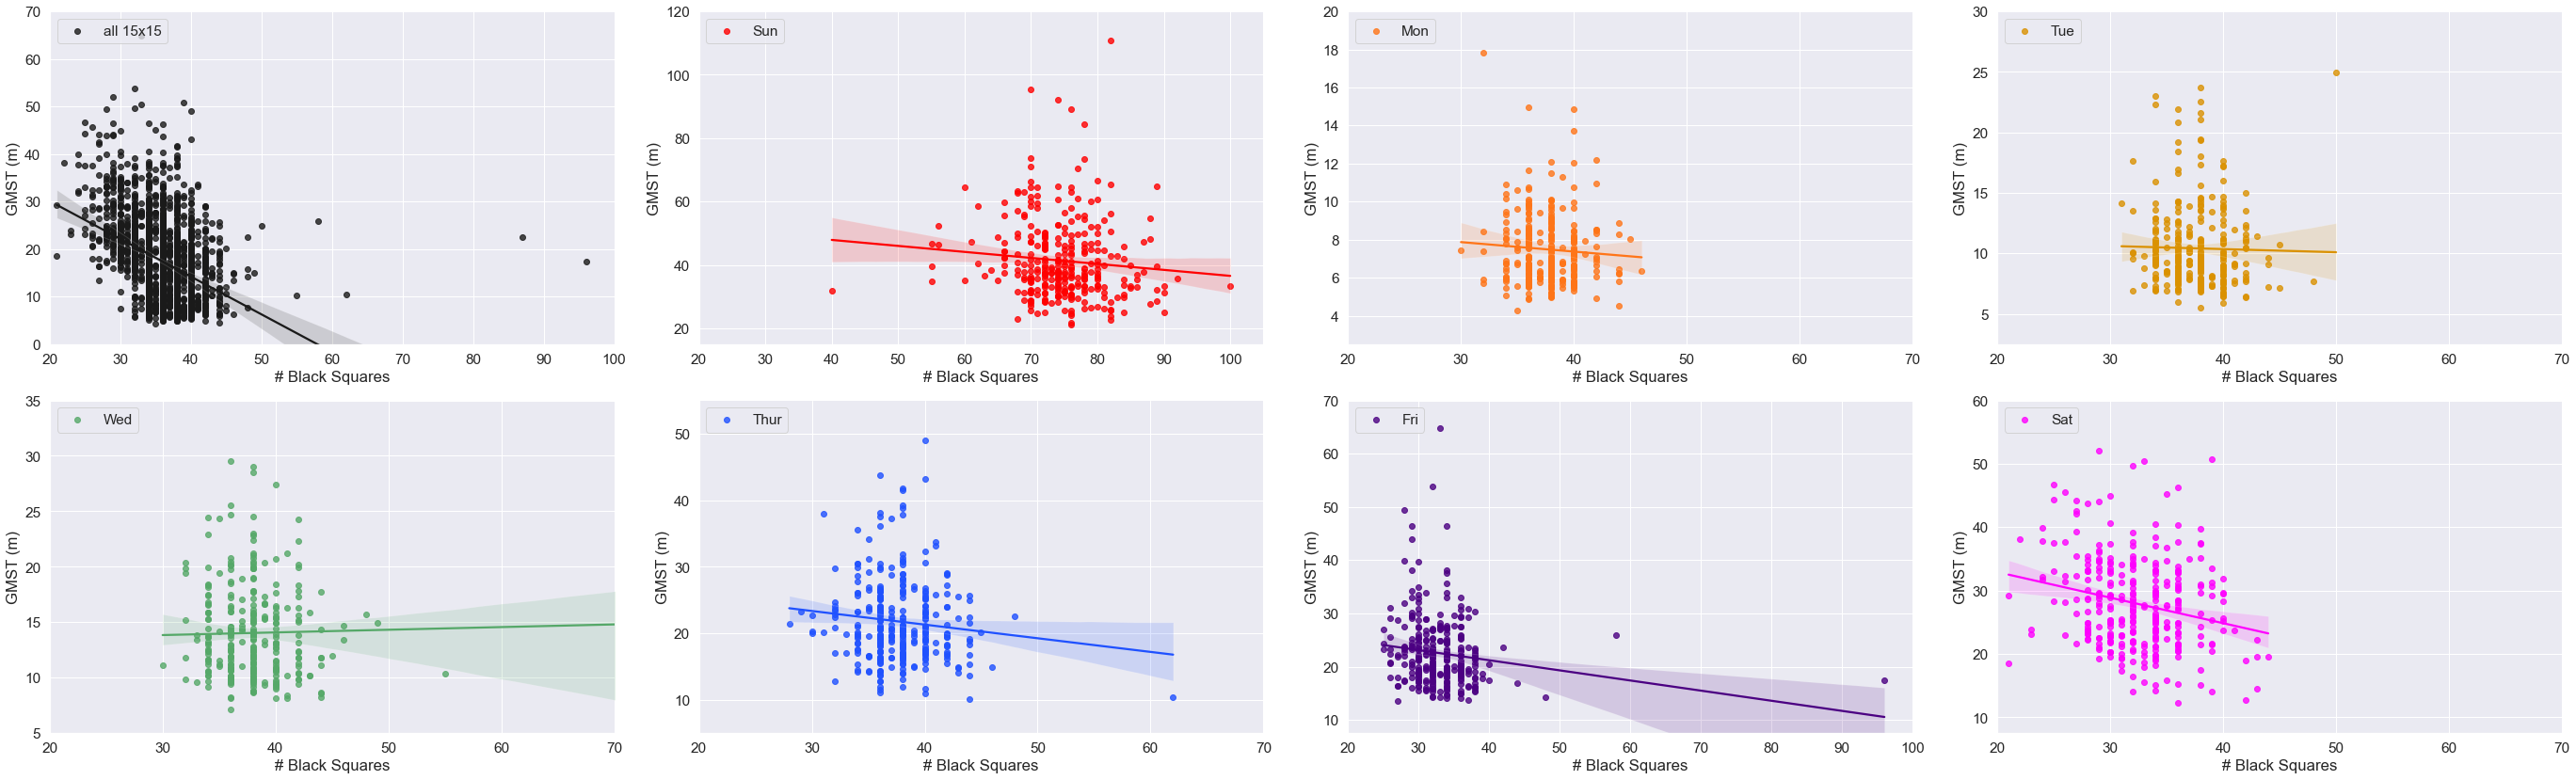

In [77]:
# Black Squares (blocks) vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Blocks", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Black Squares",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((20,100))
p.axes[1].set_xlim((20,105))
p.axes[2].set_xlim((20,70))
p.axes[3].set_xlim((20,70))
p.axes[4].set_xlim((20,70))
p.axes[5].set_xlim((20,70))
p.axes[6].set_xlim((20,100))
p.axes[7].set_xlim((20,70))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [78]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Blocks']))

-0.3949468485087781


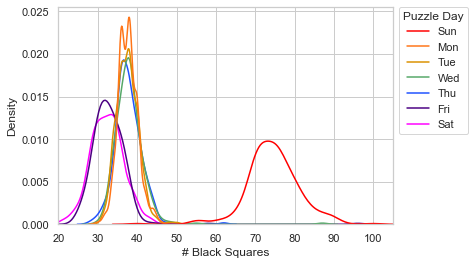

In [79]:
# Density plot of number of black squares (blocks) in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Blocks", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(20, 105)
ax.set_xlabel("# Black Squares")
plt.show()

In [80]:
df_GMS["Blocks"].agg(['min', 'max'])

min     21
max    100
Name: Blocks, dtype: int64

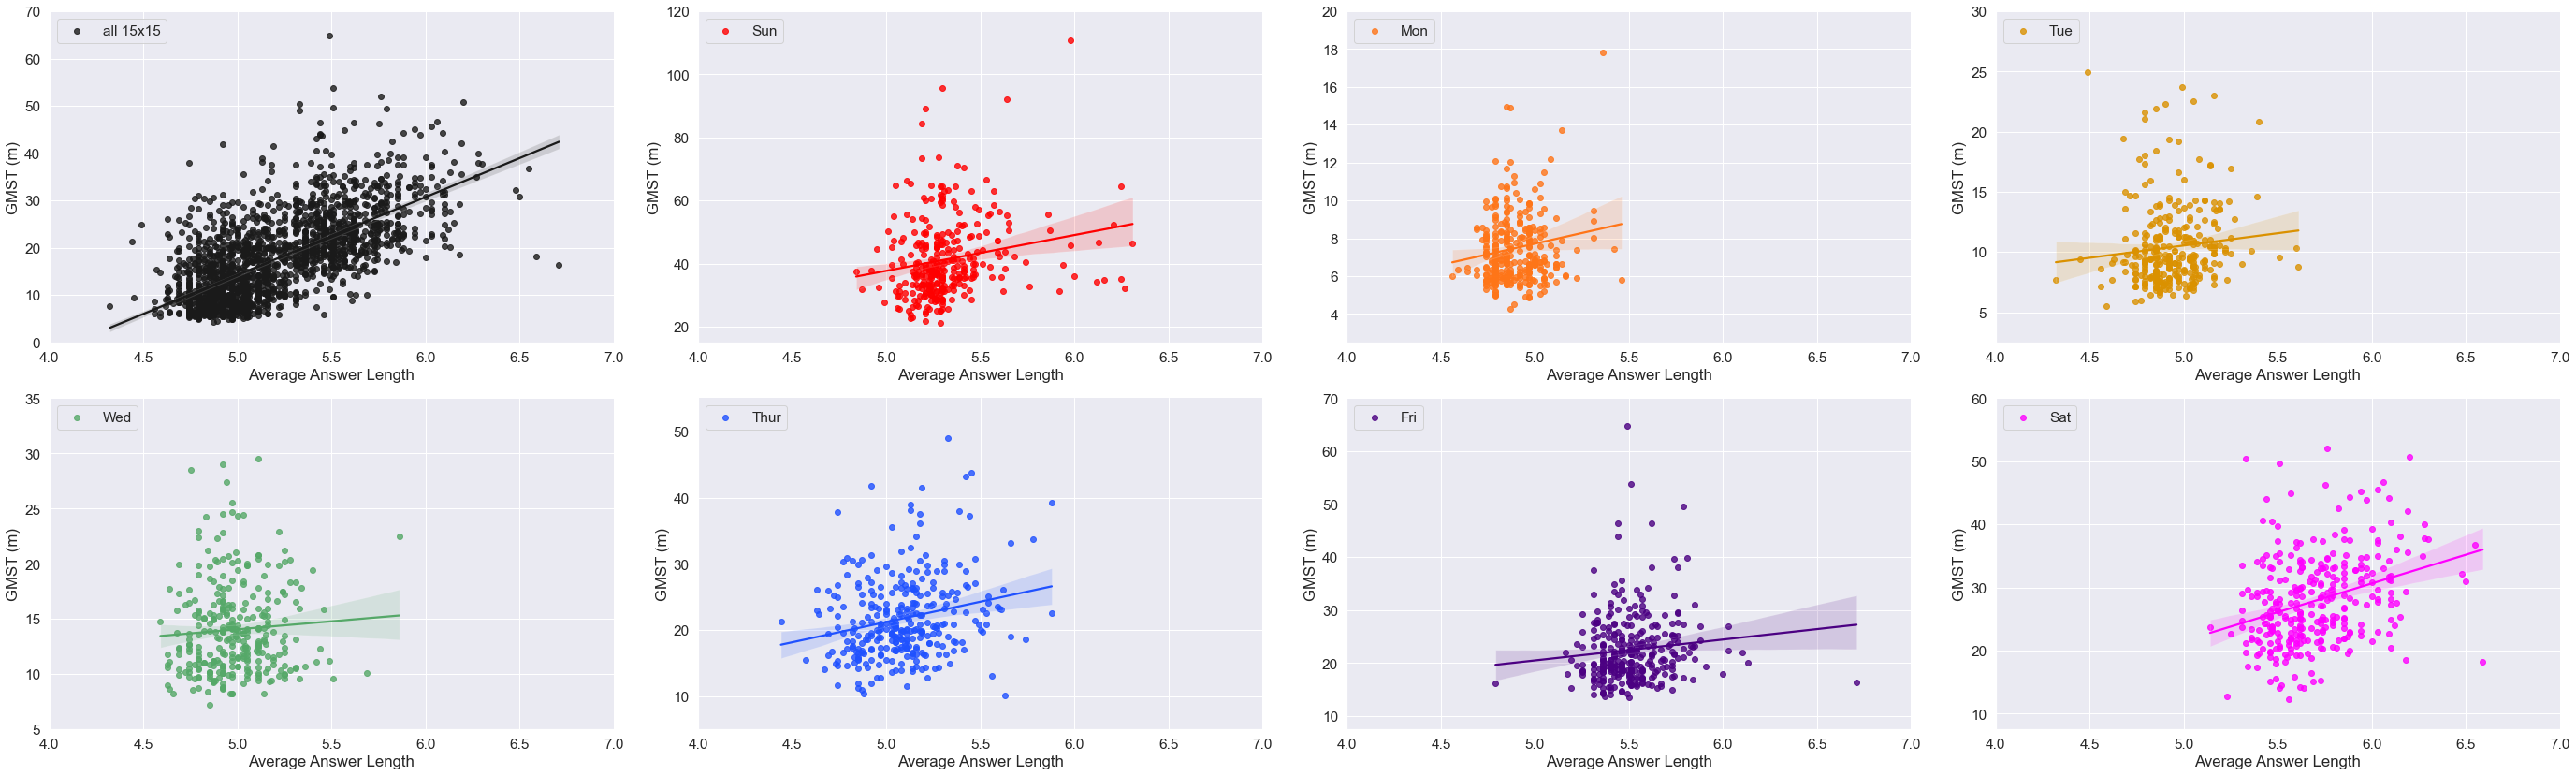

In [81]:
# Average Answer Length vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="AWL", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Average Answer Length",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((4,7))
p.axes[1].set_xlim((4,7))
p.axes[2].set_xlim((4,7))
p.axes[3].set_xlim((4,7))
p.axes[4].set_xlim((4,7))
p.axes[5].set_xlim((4,7))
p.axes[6].set_xlim((4,7))
p.axes[7].set_xlim((4,7))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [82]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['AWL']))

0.6707619946981624


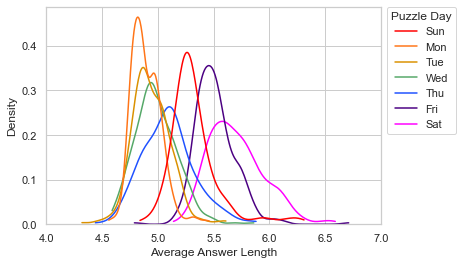

In [83]:
# Density plot of average answer length in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "AWL", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(3,7))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(4, 7)
ax.set_xlabel("Average Answer Length")
plt.show()

In [84]:
df_GMS["AWL"].agg(['min', 'max'])

min    4.32
max    6.71
Name: AWL, dtype: float64

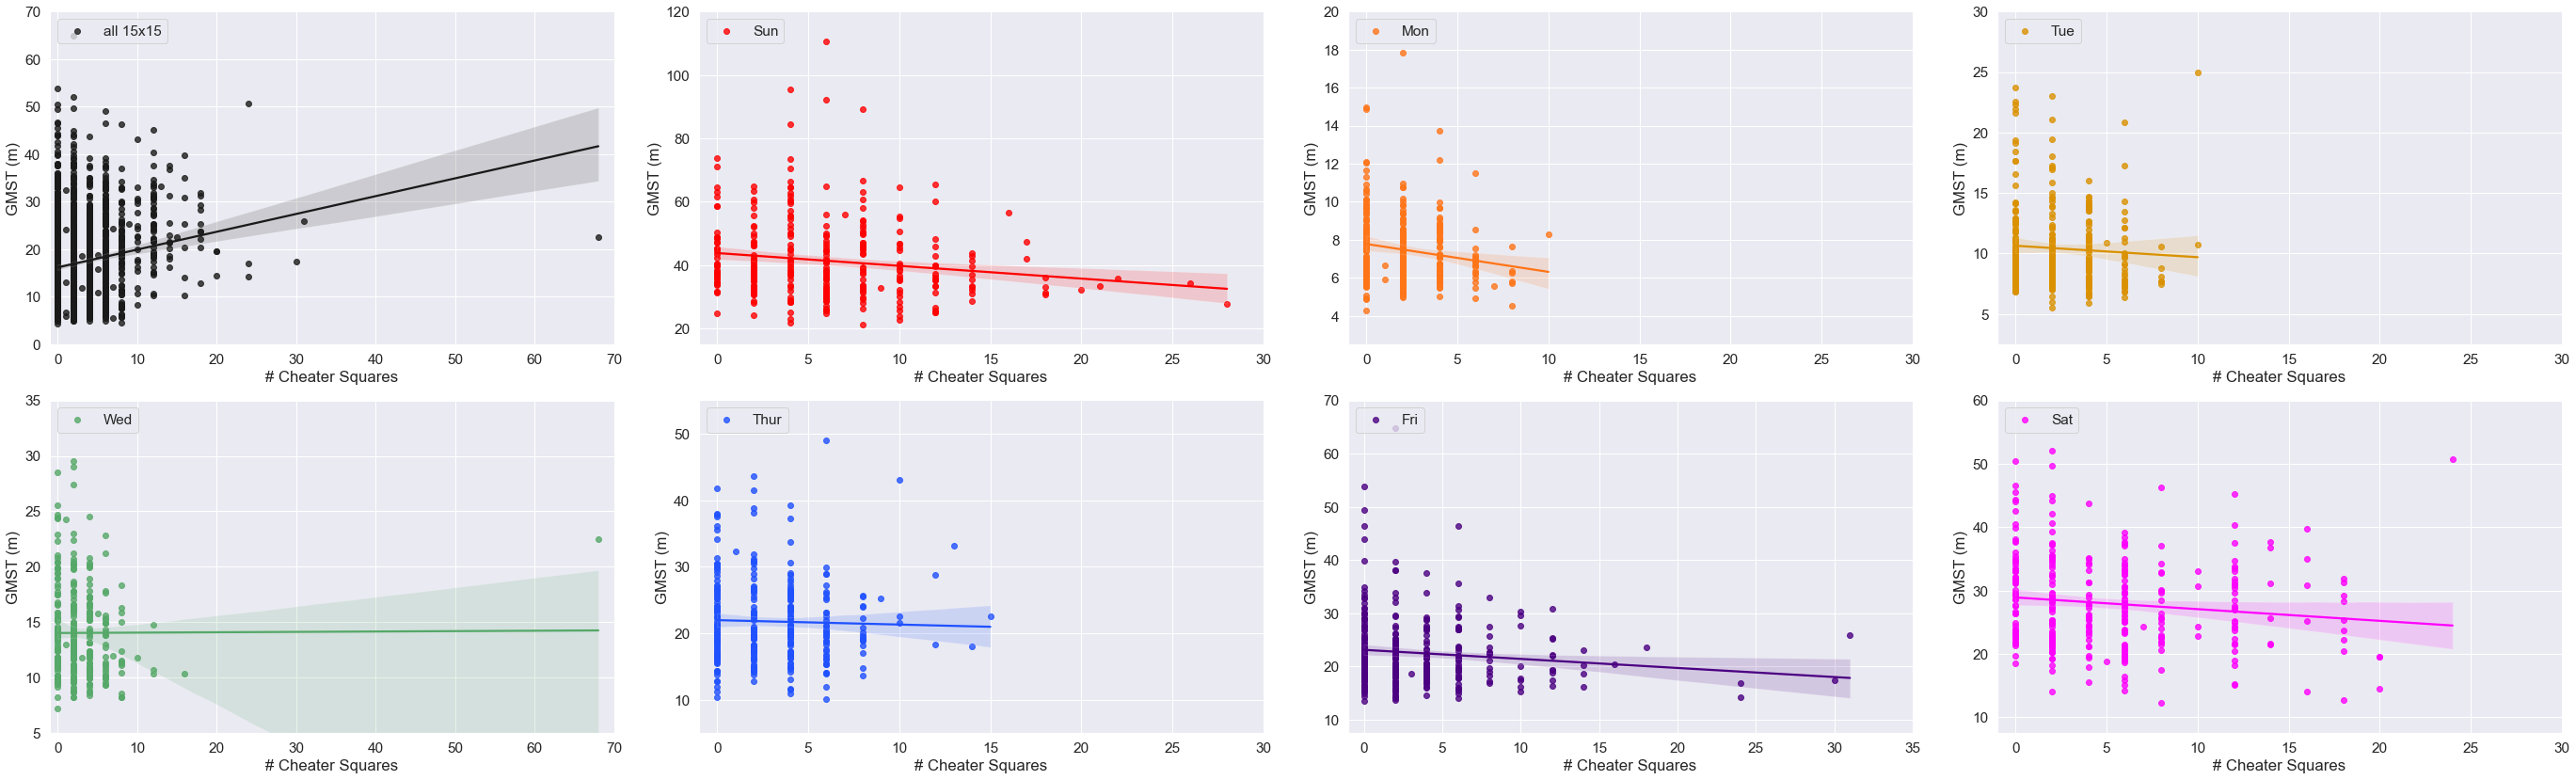

In [85]:
# Cheater Squares vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Cheater_Squares", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Cheater Squares",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,70))
p.axes[1].set_xlim((-1,30))
p.axes[2].set_xlim((-1,30))
p.axes[3].set_xlim((-1,30))
p.axes[4].set_xlim((-1,70))
p.axes[5].set_xlim((-1,30))
p.axes[6].set_xlim((-1,35))
p.axes[7].set_xlim((-1,30))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [86]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Cheater_Squares']))

0.16044555929134452


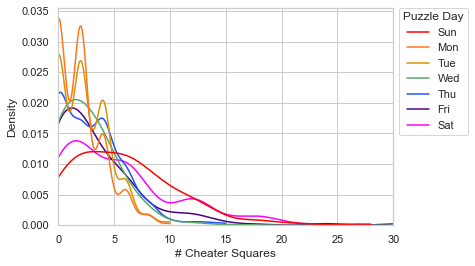

In [87]:
# Density plot of number of cheater squares in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Cheater_Squares", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 30)
ax.set_xlabel("# Cheater Squares")
plt.show()

In [88]:
df_GMS["Cheater_Squares"].agg(['min', 'max'])

min     0
max    68
Name: Cheater_Squares, dtype: int64

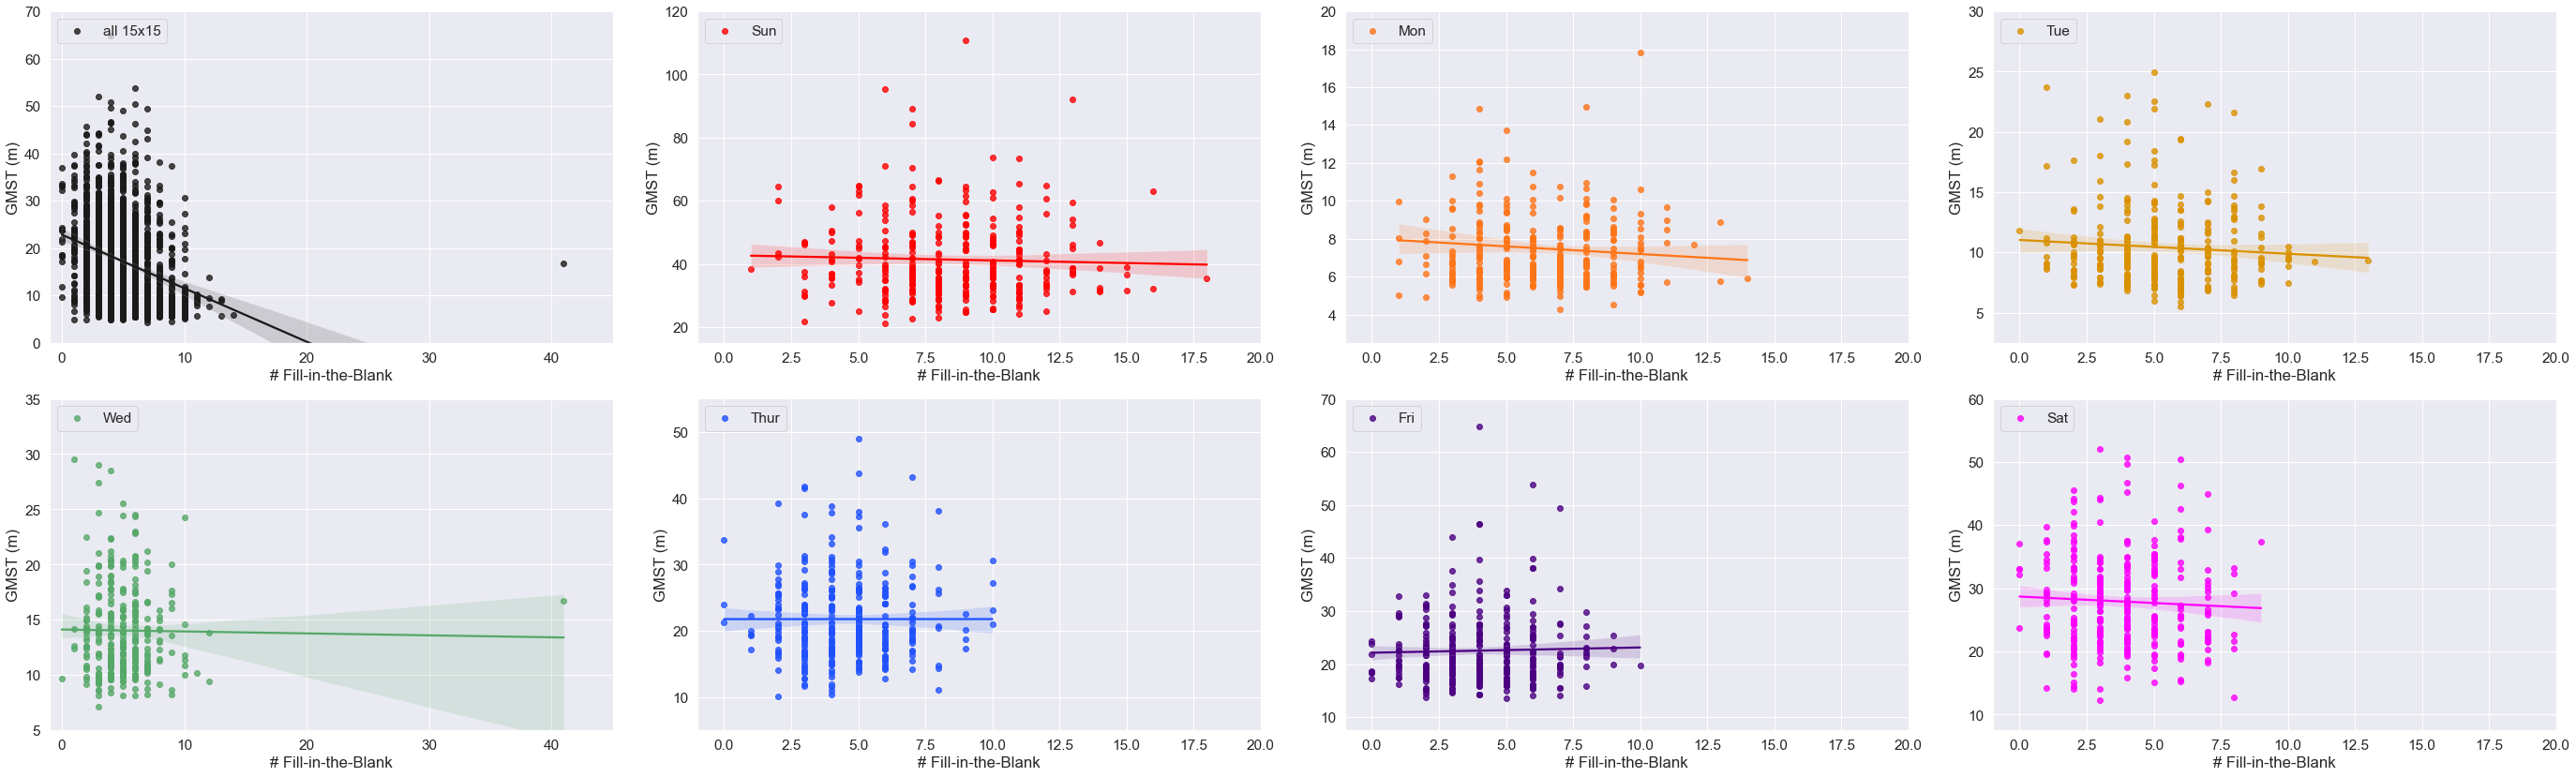

In [89]:
# Fill-in-the-blank answers vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="FITB", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Fill-in-the-Blank",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,45))
p.axes[1].set_xlim((-1,20))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,45))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [90]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['FITB']))

-0.29783180619344357


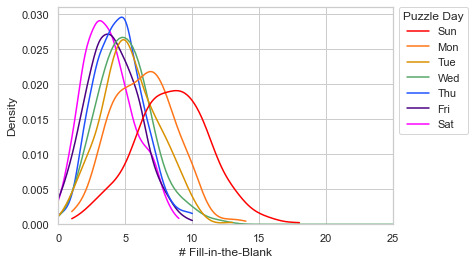

In [91]:
# Density plot of number of fill-in-the-blank clues in puzzles solved by IS1
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "FITB", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,45))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("# Fill-in-the-Blank")
plt.show()

In [92]:
df_GMS["FITB"].agg(['min', 'max'])

min     0
max    41
Name: FITB, dtype: int64

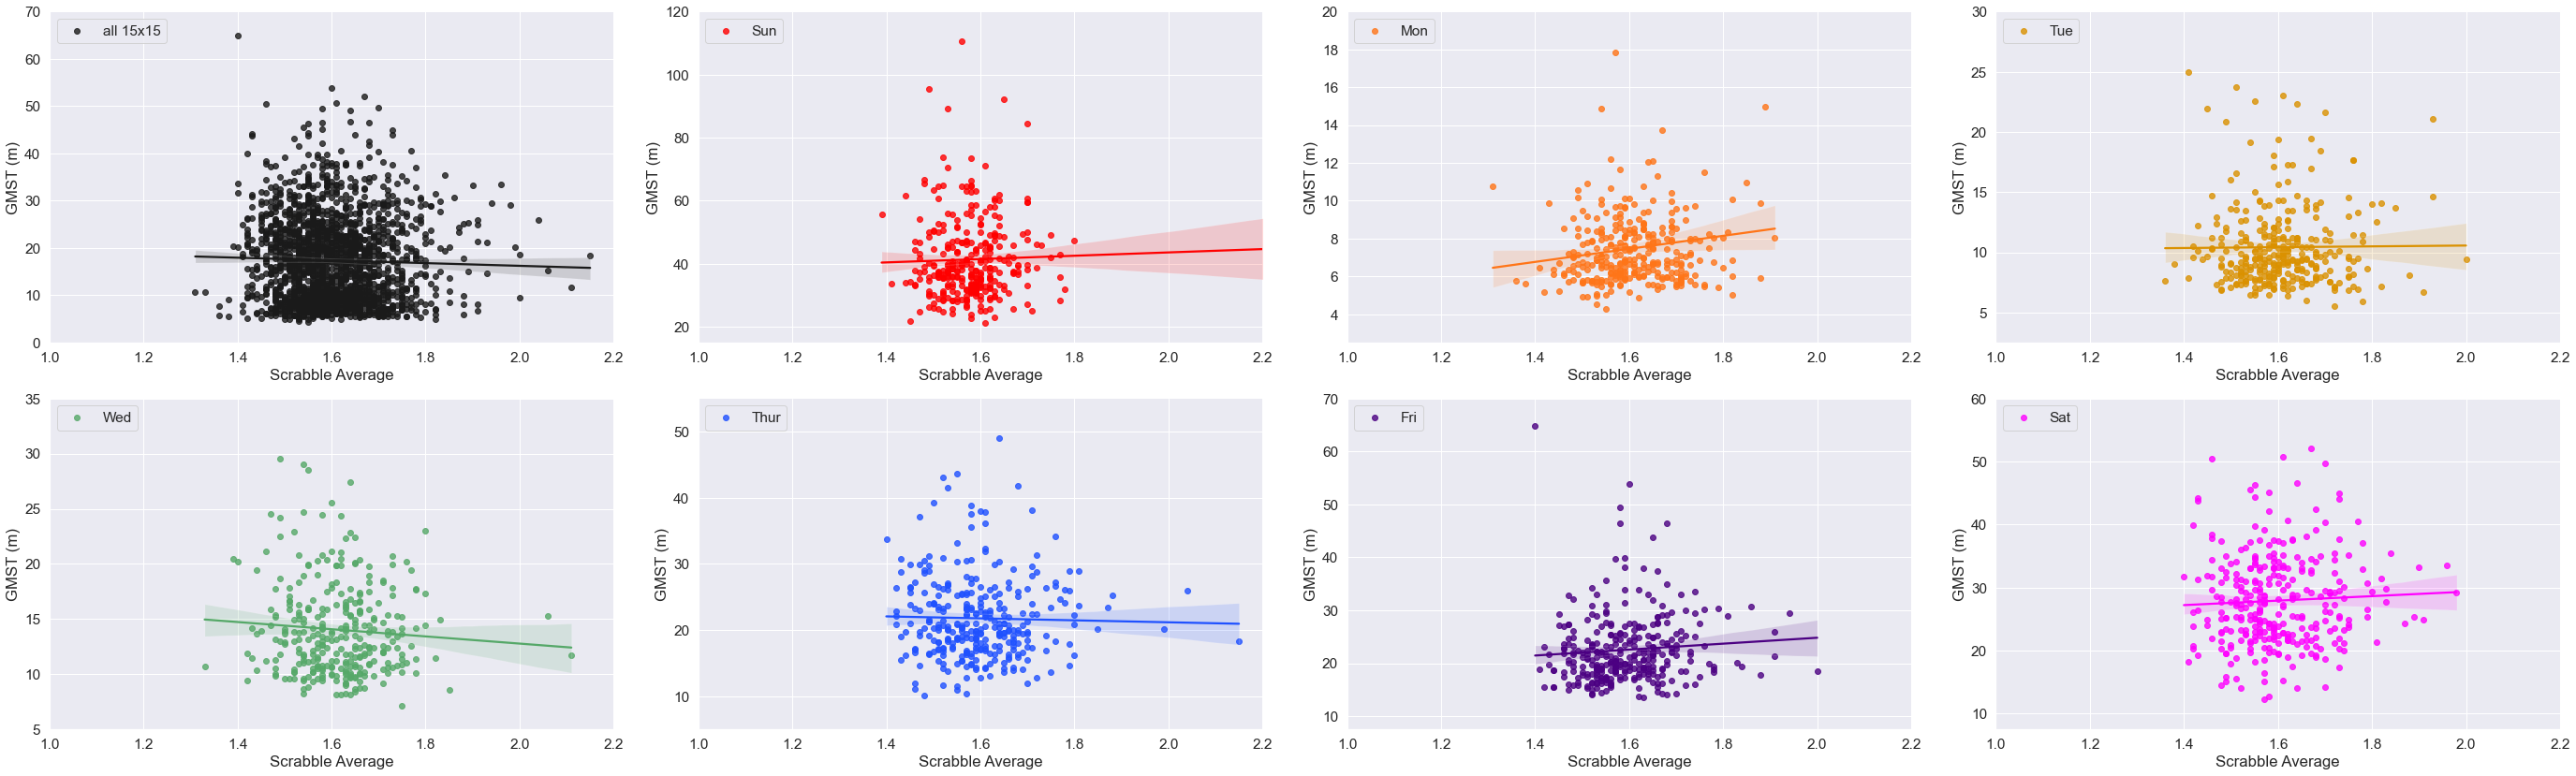

In [93]:
# Scrabble Average vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Scrabble_Avg", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Scrabble Average",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((1,2.2))
p.axes[1].set_xlim((1,2.2))
p.axes[2].set_xlim((1,2.2))
p.axes[3].set_xlim((1,2.2))
p.axes[4].set_xlim((1,2.2))
p.axes[5].set_xlim((1,2.2))
p.axes[6].set_xlim((1,2.2))
p.axes[7].set_xlim((1,2.2))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [94]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Scrabble_Avg']))

-0.031240652826517938


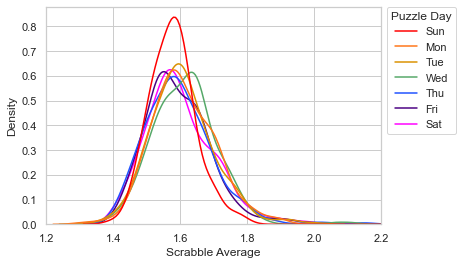

In [95]:
# Density plot of Scrabble Average in puzzles solved by IS1
# Rememember to use df because df2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Scrabble_Avg", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(1.2, 2.2)
ax.set_xlabel("Scrabble Average")
plt.show()

In [96]:
df_GMS["Scrabble_Avg"].agg(['min', 'max'])

min    1.31
max    2.45
Name: Scrabble_Avg, dtype: float64

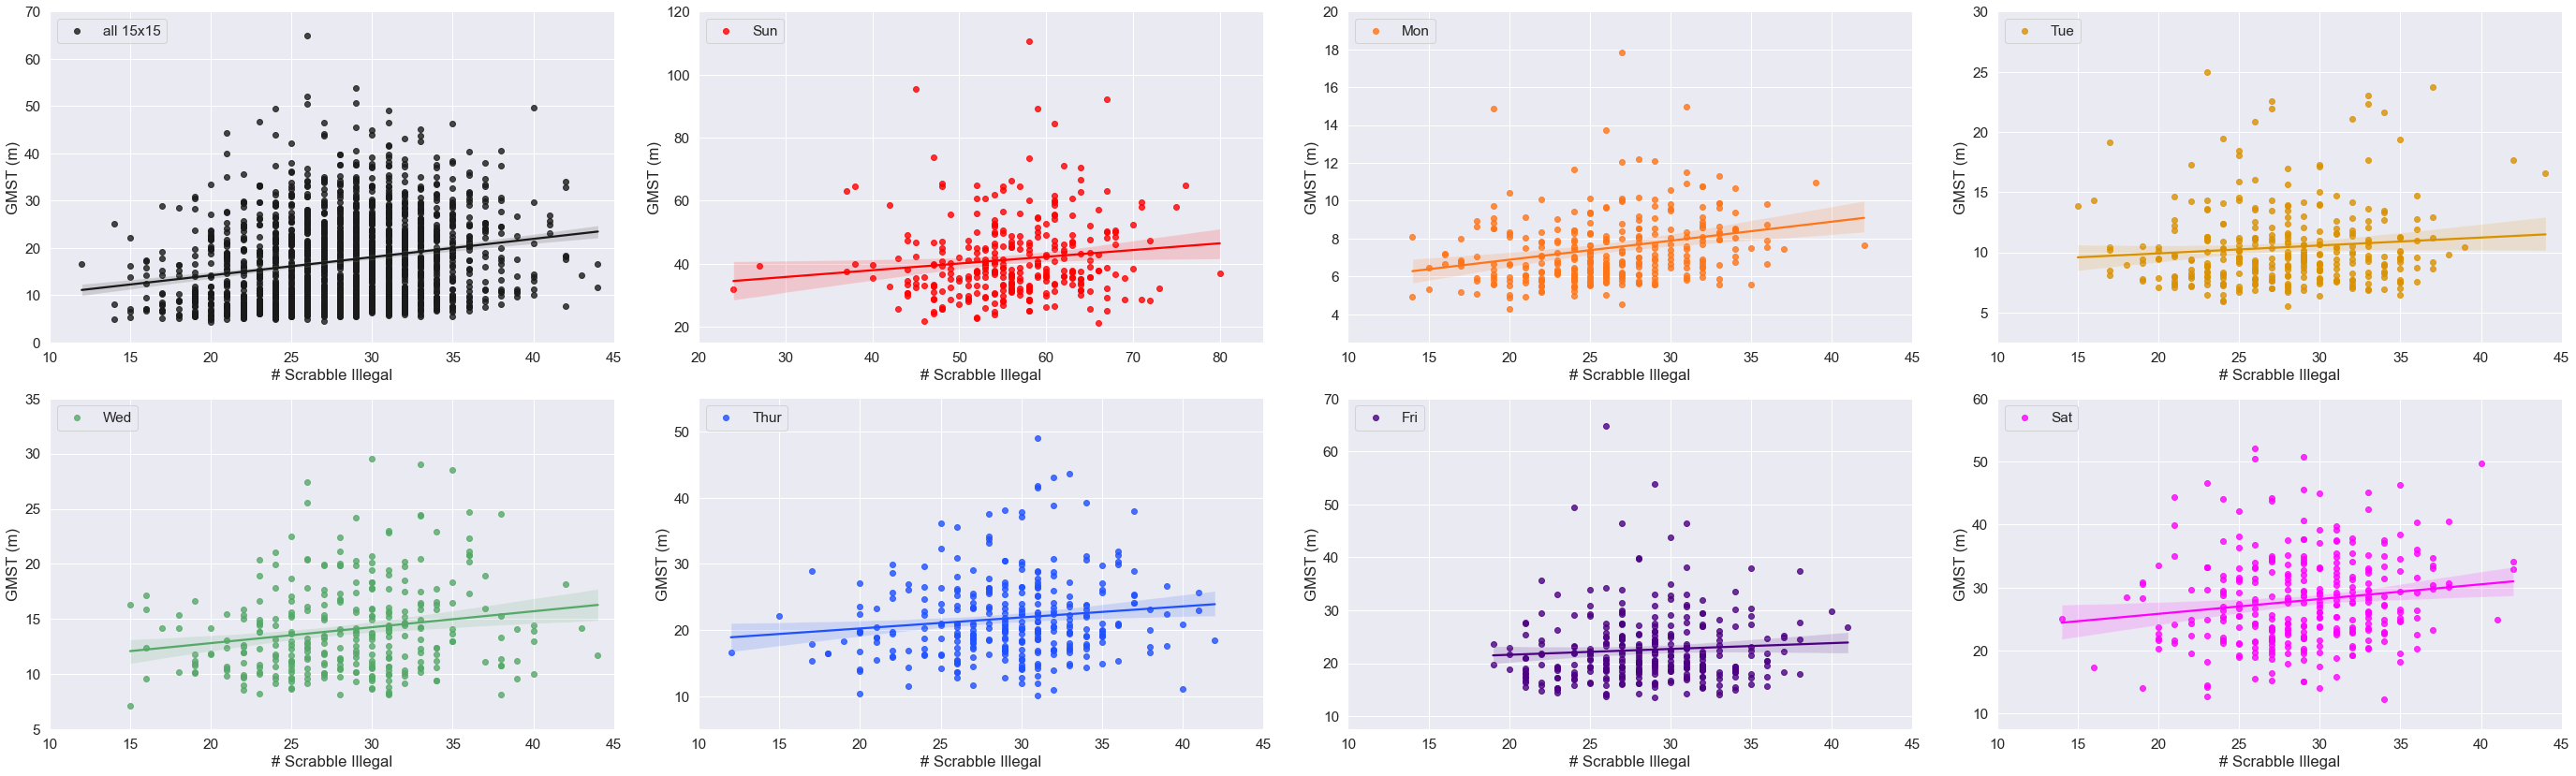

In [97]:
# Scrabble Illegal # vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Scrabble_Illegal", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Scrabble Illegal",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,45))
p.axes[1].set_xlim((20,85))
p.axes[2].set_xlim((10,45))
p.axes[3].set_xlim((10,45))
p.axes[4].set_xlim((10,45))
p.axes[5].set_xlim((10,45))
p.axes[6].set_xlim((10,45))
p.axes[7].set_xlim((10,45))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [98]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Scrabble_Illegal']))

0.2112425893393972


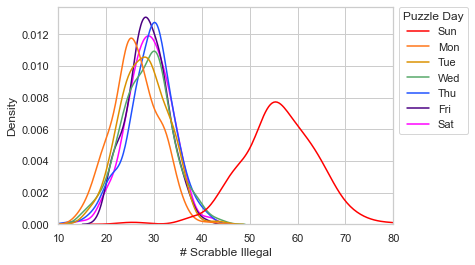

In [99]:
# Density plot of Scrabble Illegal # in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Scrabble_Illegal", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(10, 80)
ax.set_xlabel("# Scrabble Illegal")
plt.show()

In [100]:
df_GMS["Scrabble_Illegal"].agg(['min', 'max'])

min    12
max    80
Name: Scrabble_Illegal, dtype: int64

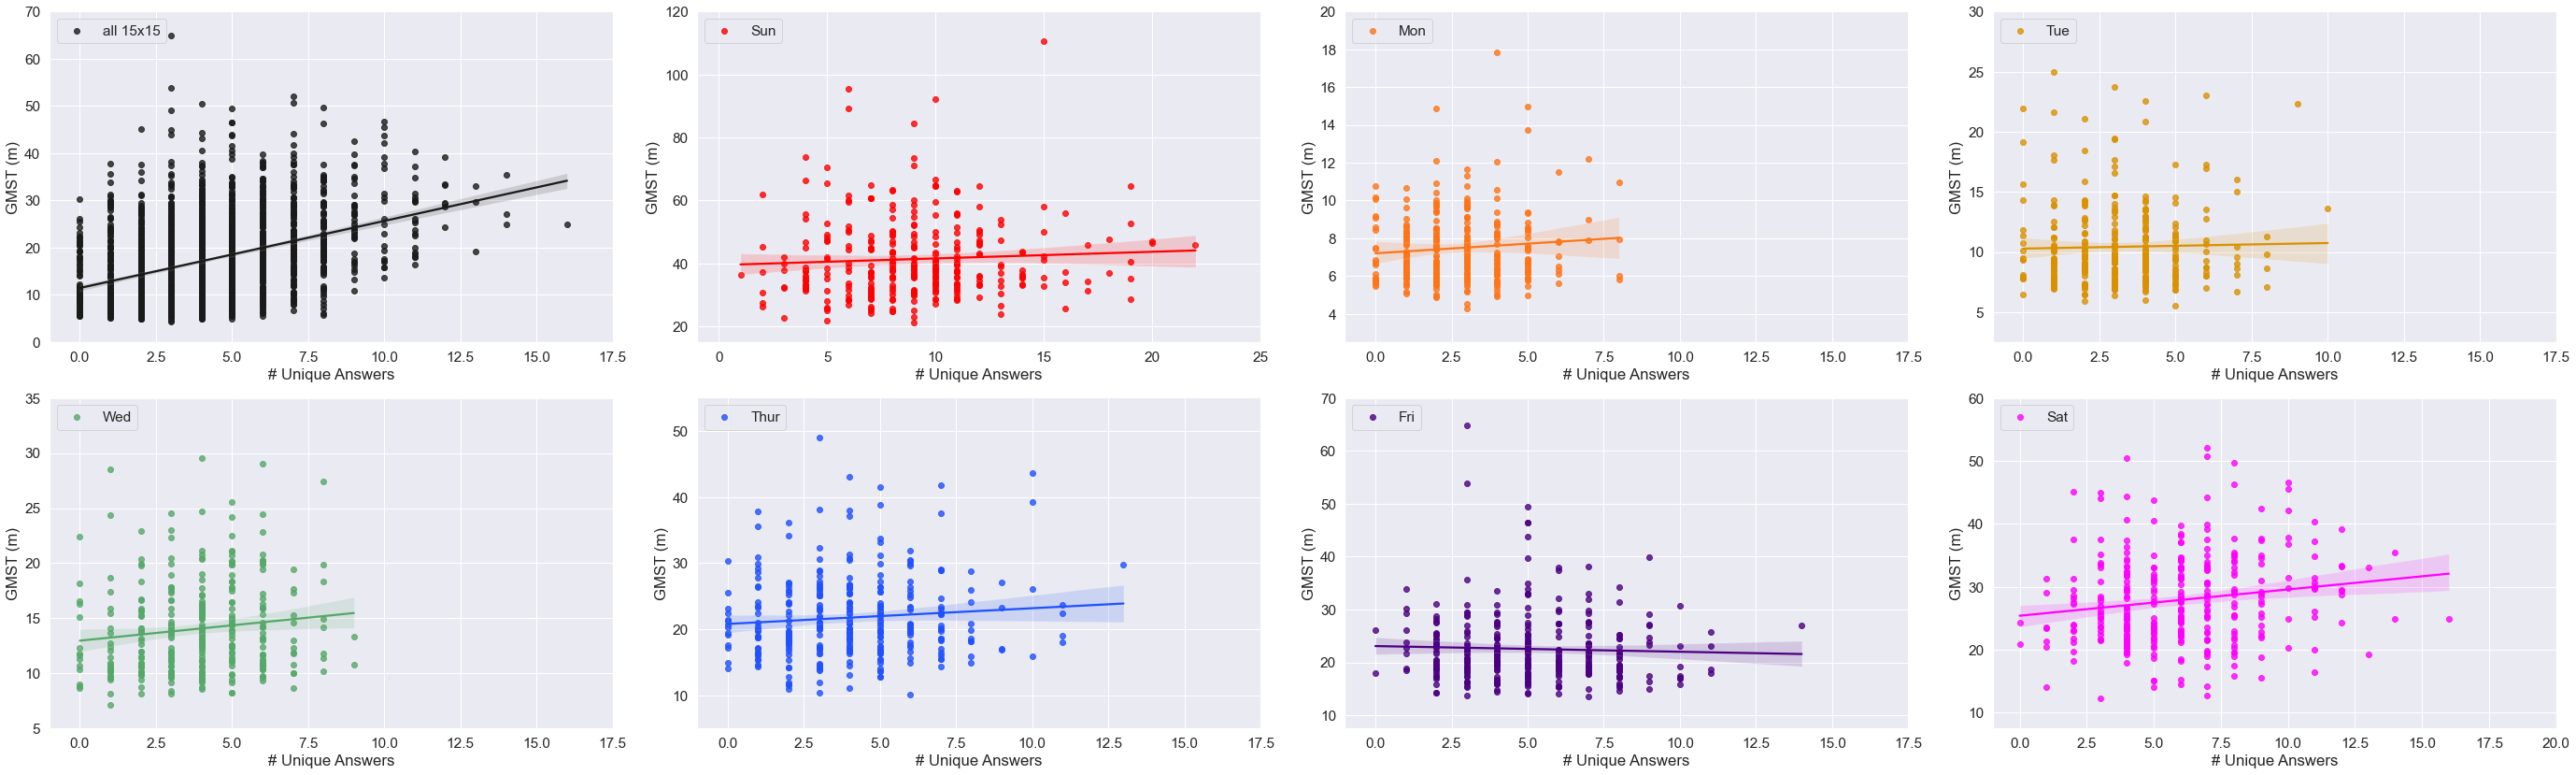

In [101]:
# Unique Answers # # vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Unique_Answers", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Unique Answers",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,17.5))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,17.5))
p.axes[3].set_xlim((-1,17.5))
p.axes[4].set_xlim((-1,17.5))
p.axes[5].set_xlim((-1,17.5))
p.axes[6].set_xlim((-1,17.5))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [102]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Unique_Answers']))

0.38765077788994


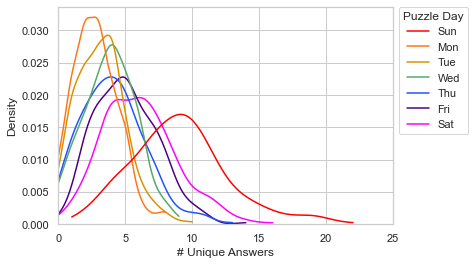

In [103]:
# Density plot of Unique Answers # in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Unique_Answers", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,25))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("# Unique Answers")
plt.show()

In [104]:
df_GMS["Unique_Answers"].agg(['min', 'max'])

min     0
max    22
Name: Unique_Answers, dtype: int64

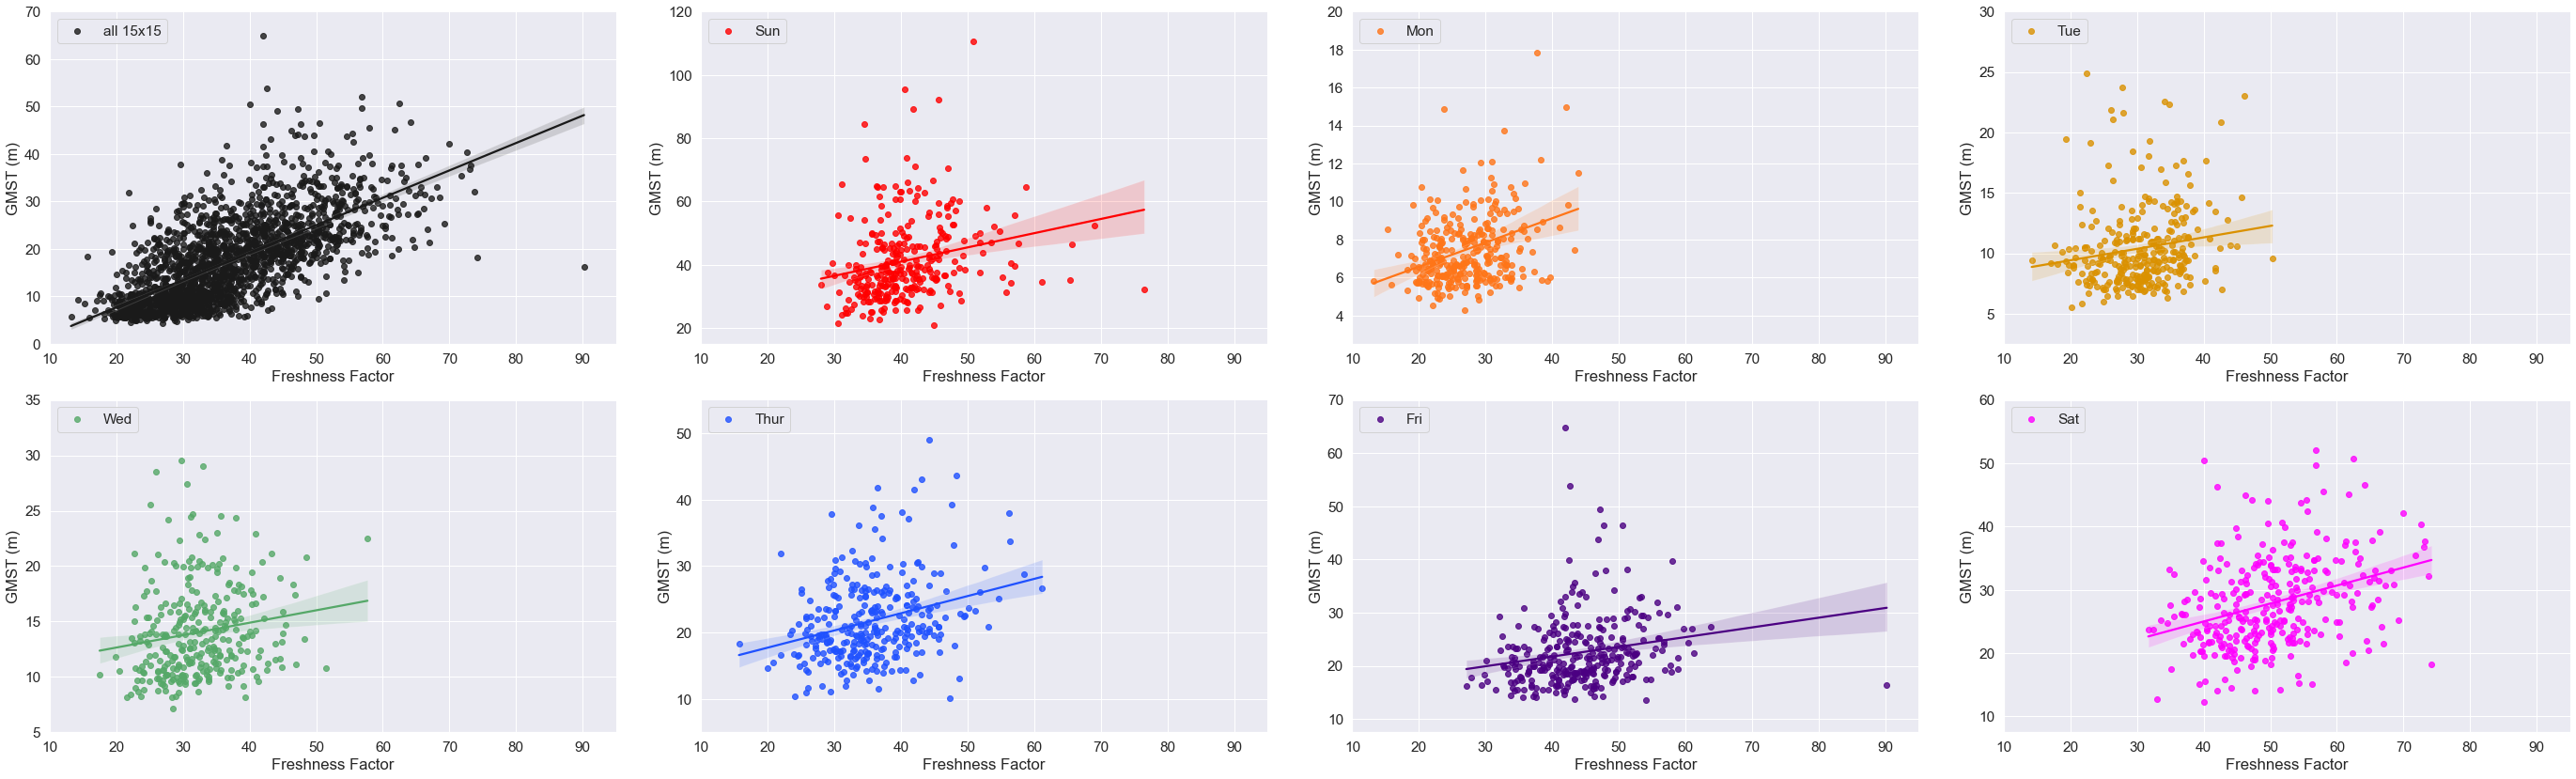

In [105]:
# Freshness Factor vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Freshness_Factor", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Freshness Factor",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,95))
p.axes[1].set_xlim((10,95))
p.axes[2].set_xlim((10,95))
p.axes[3].set_xlim((10,95))
p.axes[4].set_xlim((10,95))
p.axes[5].set_xlim((10,95))
p.axes[6].set_xlim((10,95))
p.axes[7].set_xlim((10,95))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [106]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Freshness_Factor']))

0.6778606704408325


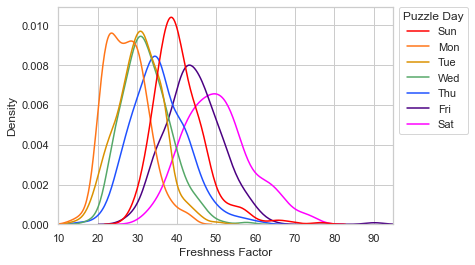

In [107]:
# Density plot of Freshness Factor in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Freshness_Factor", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(10, 95)
ax.set_xlabel("Freshness Factor")
plt.show()

In [108]:
df_GMS["Freshness_Factor"].agg(['min', 'max'])

min    13.2
max    90.2
Name: Freshness_Factor, dtype: float64

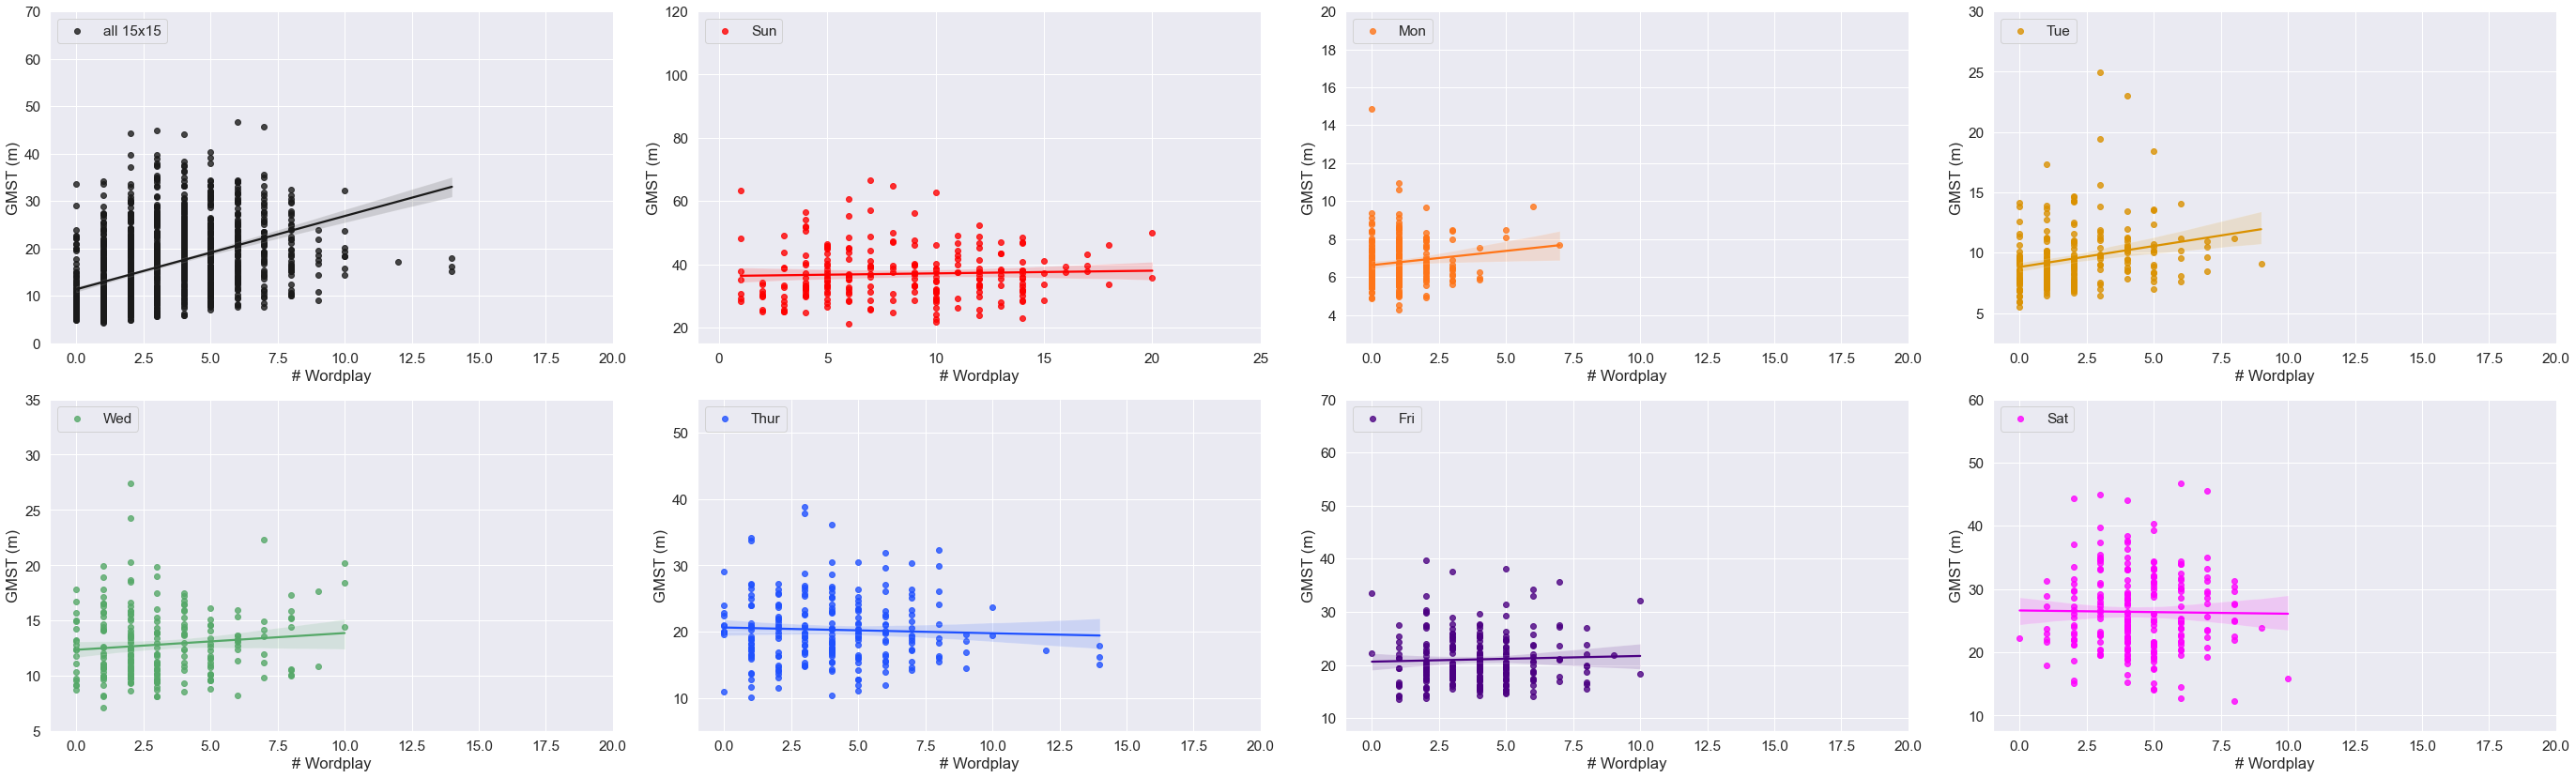

In [109]:
# Wordplay vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Wordplay", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Wordplay",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,20))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,20))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [110]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Wordplay']))

0.44020268869828844


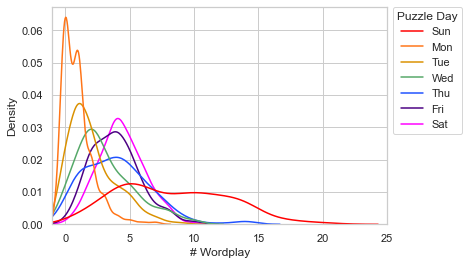

In [111]:
# Density plot of Wordplay in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Wordplay", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(-1, 25)
ax.set_xlabel("# Wordplay")
plt.show()

In [112]:
df_GMS["Wordplay"].agg(['min', 'max'])

min     0.0
max    20.0
Name: Wordplay, dtype: float64

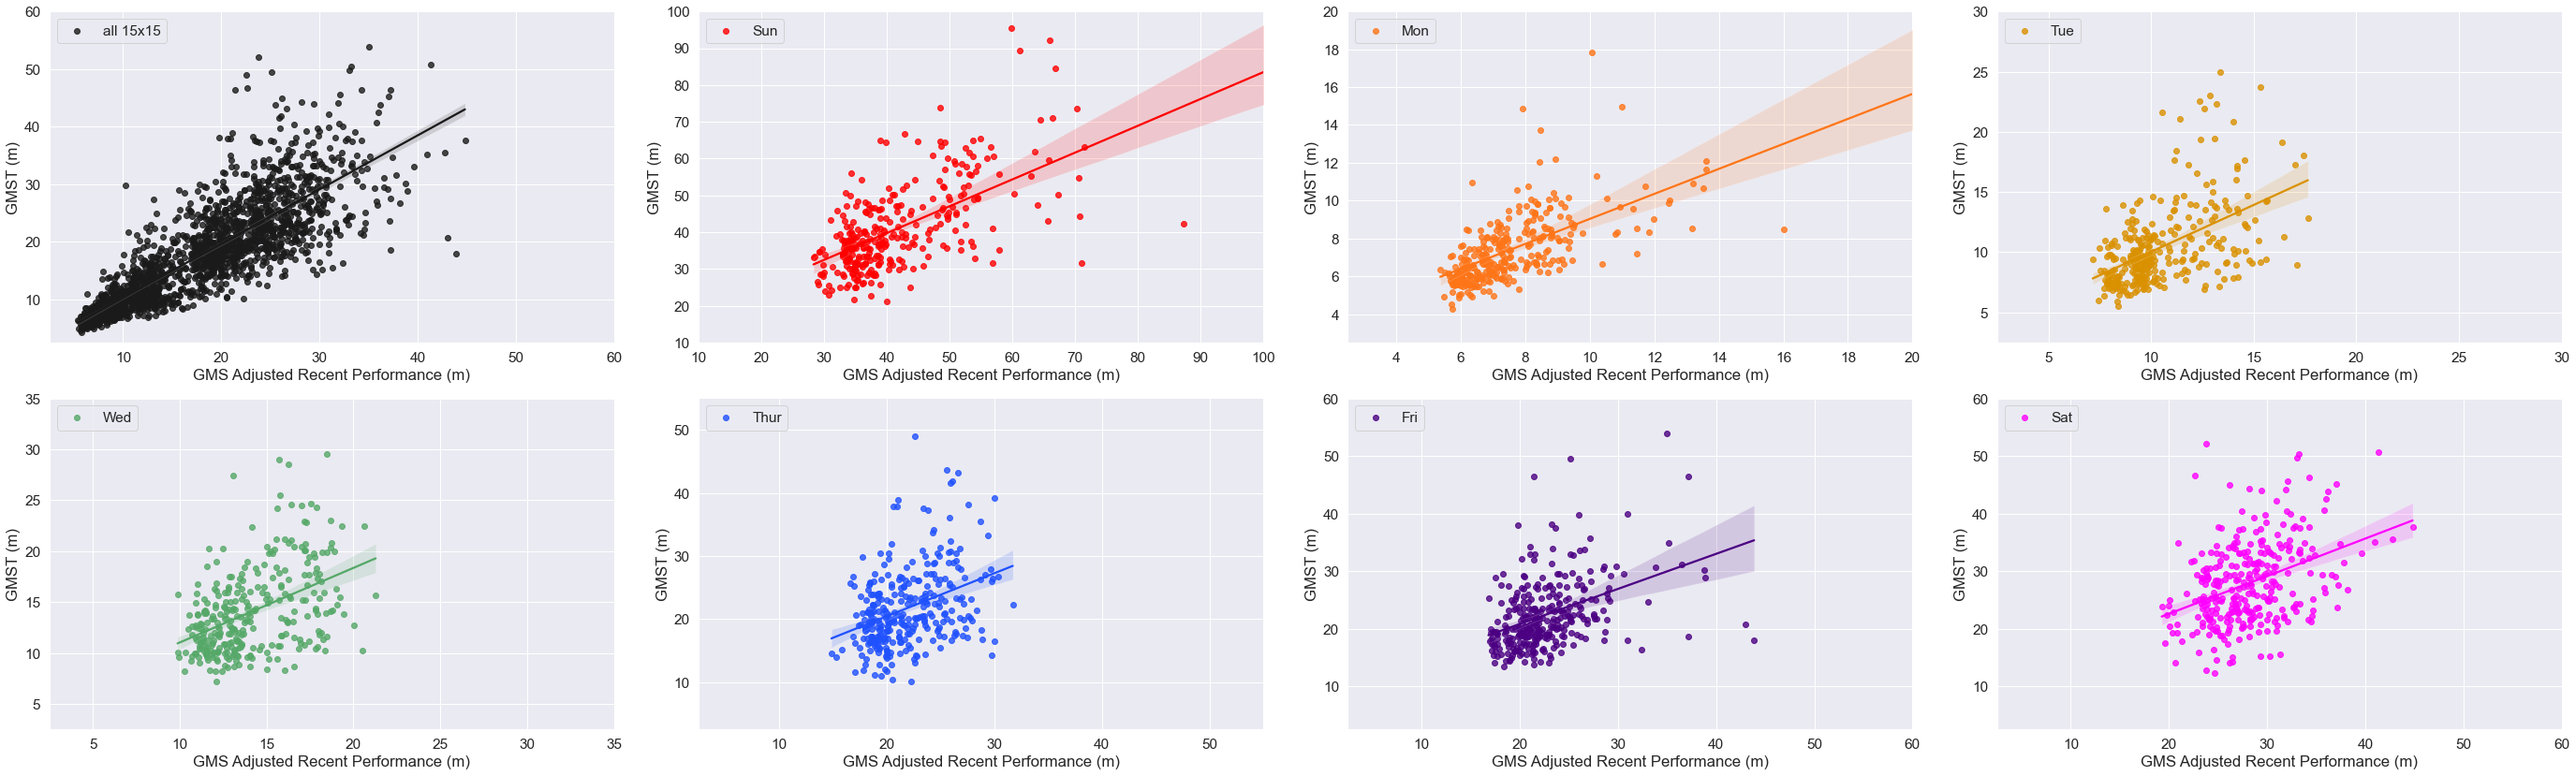

In [113]:
# GMS Recent Past Performance (Time-Decay Weighted Immediately Previous 10 Puzzles Prior to a given puzzle) vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="GMS_pds_l10_dw", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "GMS Adjusted Recent Performance (m)",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((2.5,60))
p.axes[1].set_xlim((10,100))
p.axes[2].set_xlim((2.5,20))
p.axes[3].set_xlim((2.5,30))
p.axes[4].set_xlim((2.5,35))
p.axes[5].set_xlim((2.5,55))
p.axes[6].set_xlim((2.5,60))
p.axes[7].set_xlim((2.5,60))

p.axes[0].set_ylim((2.5,60))
p.axes[1].set_ylim((10,100))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((2.5,35))
p.axes[5].set_ylim((2.5,55))
p.axes[6].set_ylim((2.5,60))
p.axes[7].set_ylim((2.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [119]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['GMS_pds_l10_dw']))

GMS_Sun = df_GMS.loc[df_GMS["DOW"]==("Sunday")]
print(GMS_Sun['GMST(m)'].corr(GMS_Sun['GMS_pds_l10_dw']))

GMS_Mon = df_GMS.loc[df_GMS["DOW"]==("Monday")]
print(GMS_Mon['GMST(m)'].corr(GMS_Mon['GMS_pds_l10_dw']))

GMS_Tue = df_GMS.loc[df_GMS["DOW"]==("Tuesday")]
print(GMS_Tue['GMST(m)'].corr(GMS_Tue['GMS_pds_l10_dw']))

GMS_Wed = df_GMS.loc[df_GMS["DOW"]==("Wednesday")]
print(GMS_Wed['GMST(m)'].corr(GMS_Wed['GMS_pds_l10_dw']))

GMS_Thu = df_GMS.loc[df_GMS["DOW"]==("Thursday")]
print(GMS_Thu['GMST(m)'].corr(GMS_Thu['GMS_pds_l10_dw']))

GMS_Fri = df_GMS.loc[df_GMS["DOW"]==("Friday")]
print(GMS_Fri['GMST(m)'].corr(GMS_Fri['GMS_pds_l10_dw']))

GMS_Sat = df_GMS.loc[df_GMS["DOW"]==("Saturday")]
print(GMS_Sat['GMST(m)'].corr(GMS_Sat['GMS_pds_l10_dw']))

0.8375238828296654
0.6242596498179201
0.5464903084604616
0.5117136466242976
0.44805783106523756
0.36704448315756294
0.4019581454567099
0.38671643359167013


In [ ]:
df_GMS.to_csv('../data/df_GMS.csv', index=False)

### Data Supplement

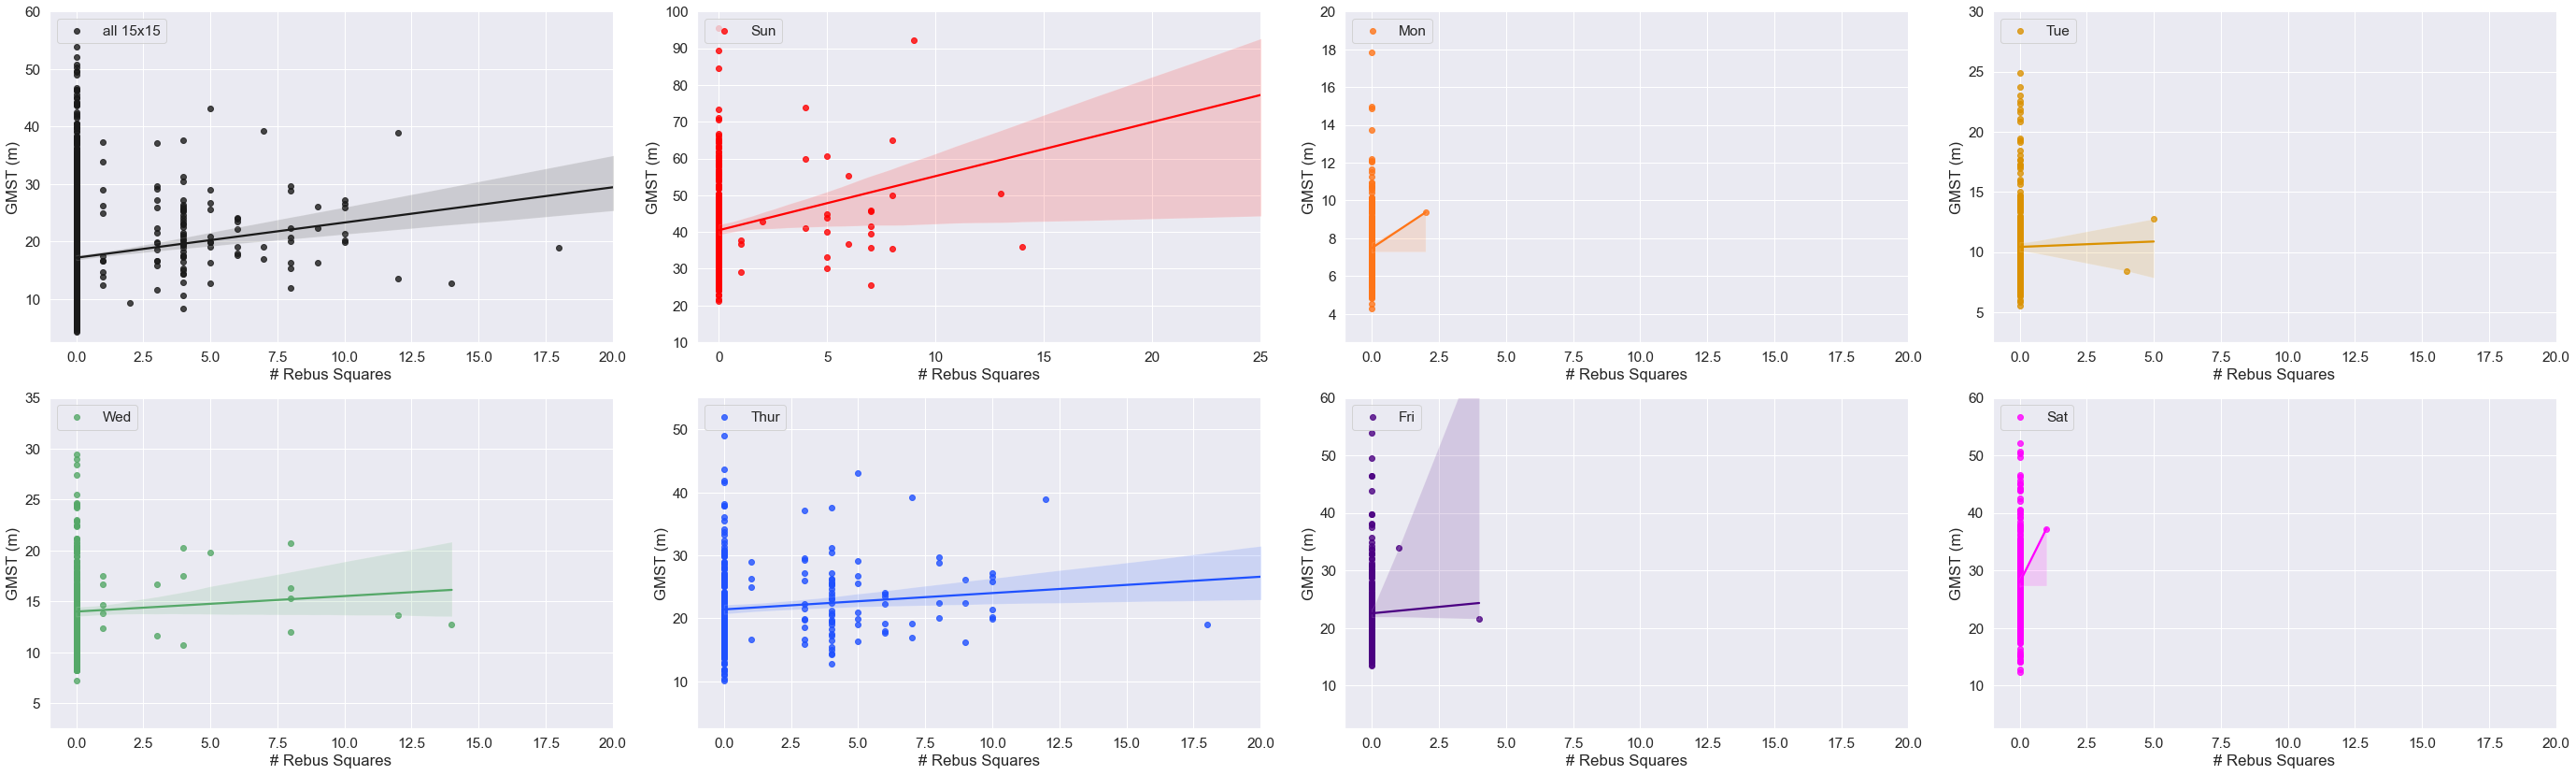

In [120]:
# Rebus # vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Rebus_Count", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Rebus Squares",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,20))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,20))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((2.5,60))
p.axes[1].set_ylim((10,100))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((2.5,35))
p.axes[5].set_ylim((2.5,55))
p.axes[6].set_ylim((2.5,60))
p.axes[7].set_ylim((2.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')


In [121]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Rebus_Count']))

print(GMS_Sun['GMST(m)'].corr(GMS_Sun['Rebus_Count']))
print(GMS_Mon['GMST(m)'].corr(GMS_Mon['Rebus_Count']))
print(GMS_Tue['GMST(m)'].corr(GMS_Tue['Rebus_Count']))
print(GMS_Wed['GMST(m)'].corr(GMS_Wed['Rebus_Count']))
print(GMS_Thu['GMST(m)'].corr(GMS_Thu['Rebus_Count']))
print(GMS_Fri['GMST(m)'].corr(GMS_Fri['Rebus_Count']))
print(GMS_Sat['GMST(m)'].corr(GMS_Sat['Rebus_Count']))

0.10098858557300844
0.2962274409120943
0.04605176633954699
0.00966769641602472
0.05399631903930267
0.12626959250075873
0.015944761481500473
0.07311881058765098


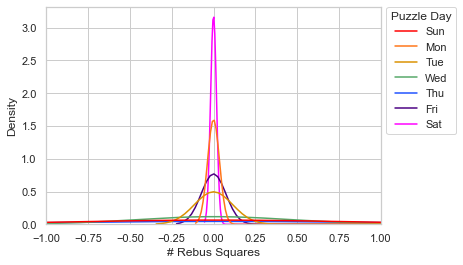

In [122]:
# Density plot of Rebus Count in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Rebus_Count", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(-1, 1)
ax.set_xlabel("# Rebus Squares")
plt.show()

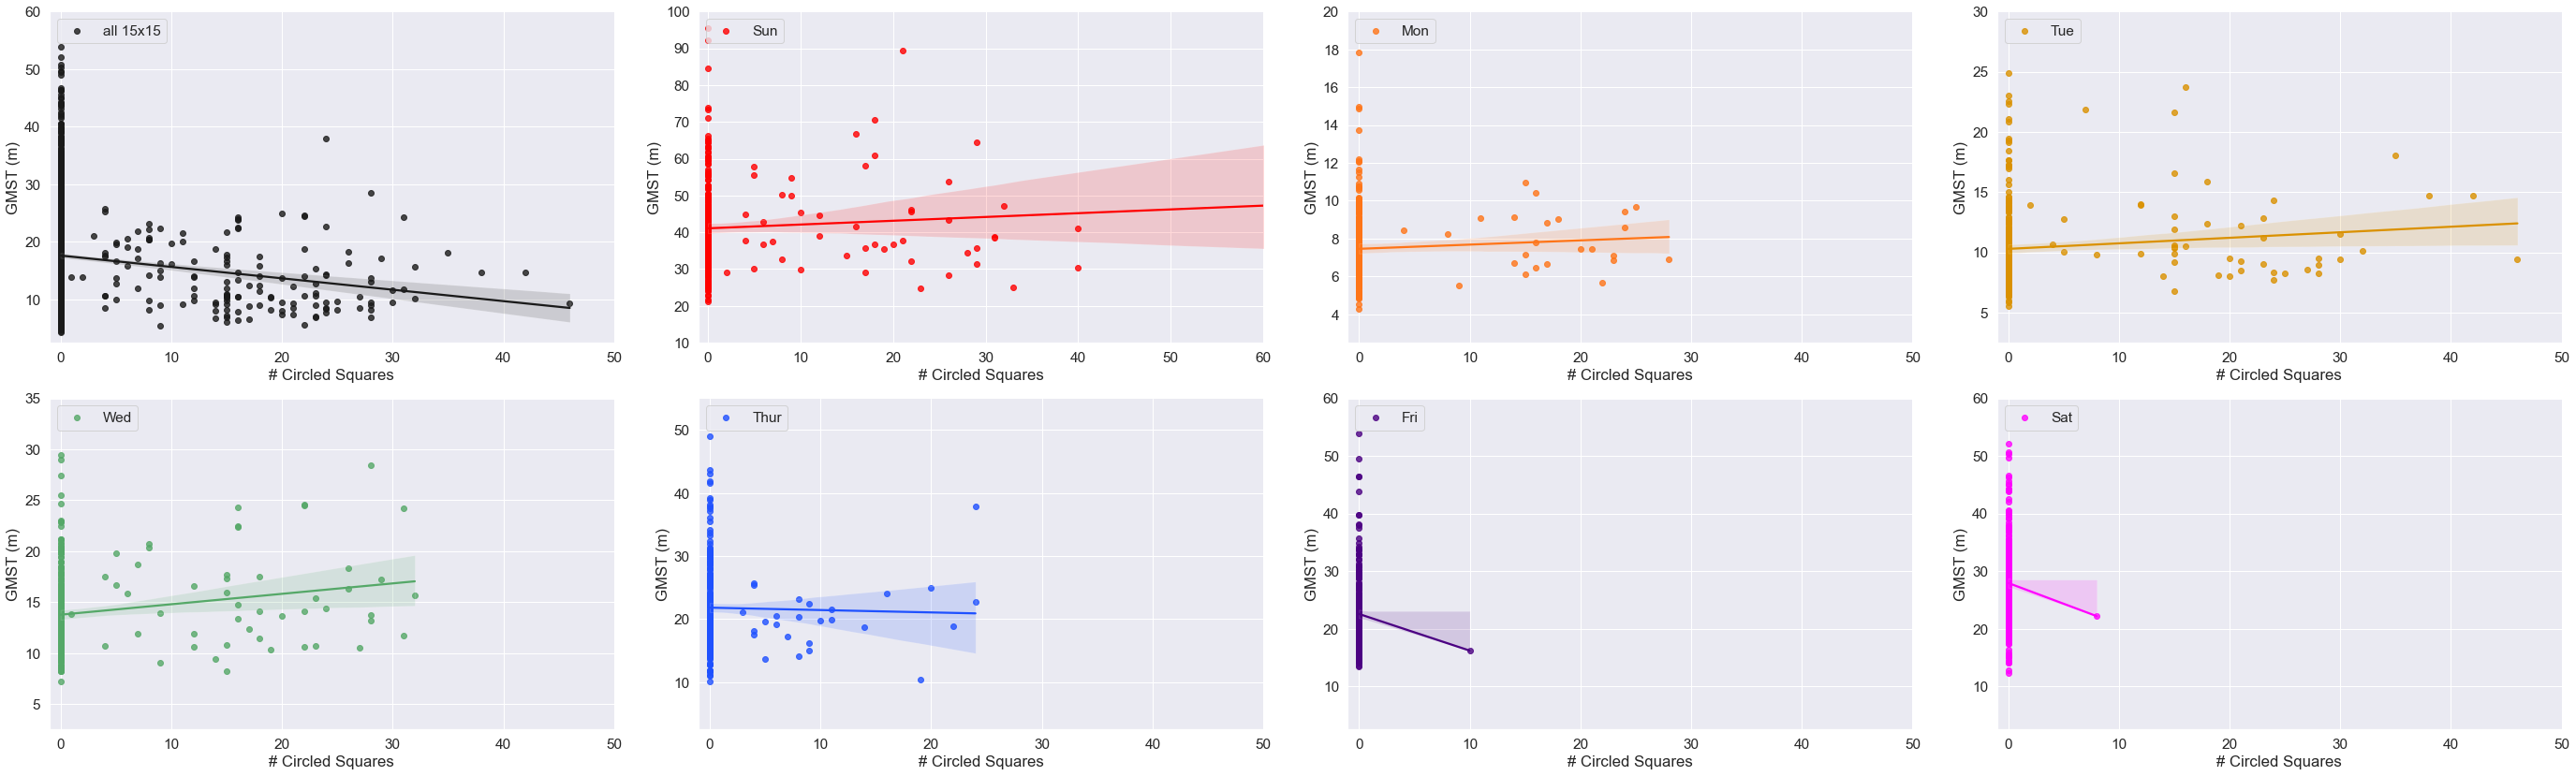

In [123]:
# Circle # vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Circle_Count", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Circled Squares",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,50))
p.axes[1].set_xlim((-1,60))
p.axes[2].set_xlim((-1,50))
p.axes[3].set_xlim((-1,50))
p.axes[4].set_xlim((-1,50))
p.axes[5].set_xlim((-1,50))
p.axes[6].set_xlim((-1,50))
p.axes[7].set_xlim((-1,50))

p.axes[0].set_ylim((2.5,60))
p.axes[1].set_ylim((10,100))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((2.5,35))
p.axes[5].set_ylim((2.5,55))
p.axes[6].set_ylim((2.5,60))
p.axes[7].set_ylim((2.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [124]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Circle_Count']))

print(GMS_Sun['GMST(m)'].corr(GMS_Sun['Circle_Count']))
print(GMS_Mon['GMST(m)'].corr(GMS_Mon['Circle_Count']))
print(GMS_Tue['GMST(m)'].corr(GMS_Tue['Circle_Count']))
print(GMS_Wed['GMST(m)'].corr(GMS_Wed['Circle_Count']))
print(GMS_Thu['GMST(m)'].corr(GMS_Thu['Circle_Count']))
print(GMS_Fri['GMST(m)'].corr(GMS_Fri['Circle_Count']))
print(GMS_Sat['GMST(m)'].corr(GMS_Sat['Circle_Count']))

-0.11283106705082639
0.067792401549882
0.04705984671096063
0.1102614886693475
0.17278252381906686
-0.020612246160837636
-0.05499339577845008
-0.045091300519988615


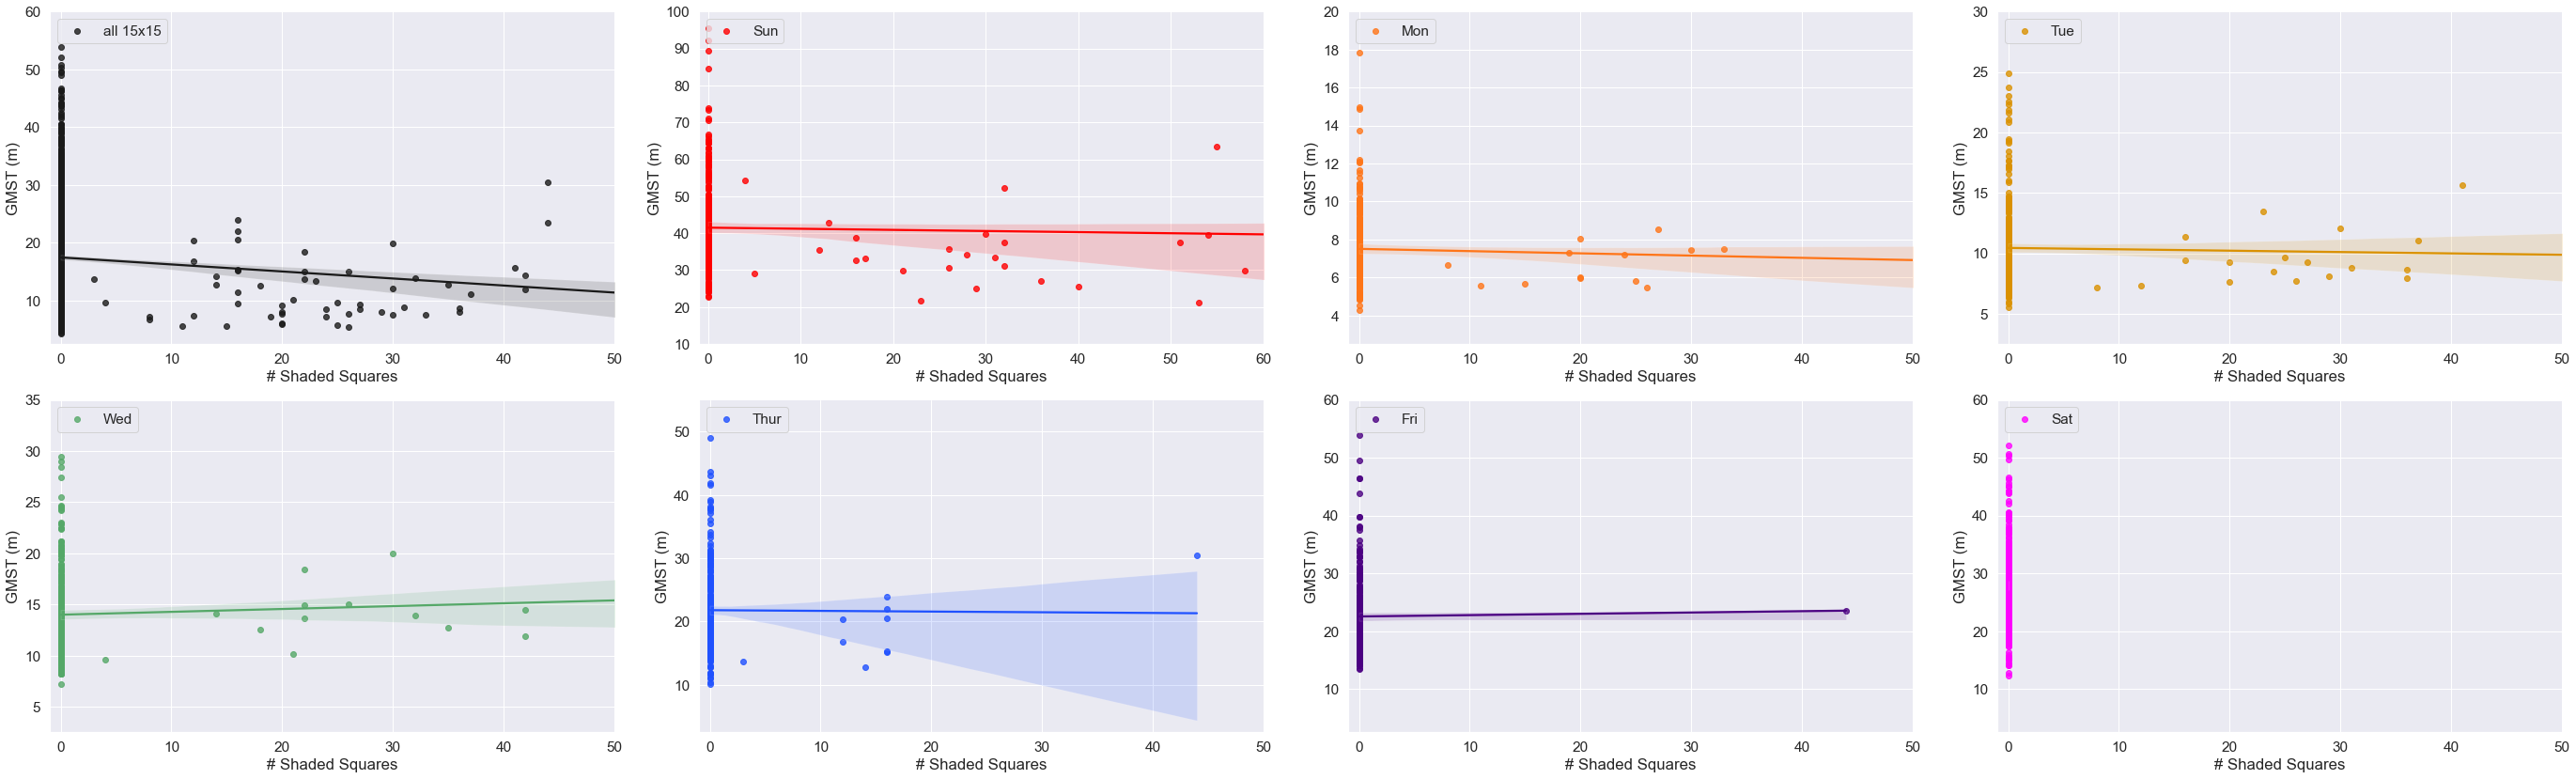

In [125]:
# Shaded Square # vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Shade_Count", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel="# Shaded Squares",
    ylabel="GMST (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,50))
p.axes[1].set_xlim((-1,60))
p.axes[2].set_xlim((-1,50))
p.axes[3].set_xlim((-1,50))
p.axes[4].set_xlim((-1,50))
p.axes[5].set_xlim((-1,50))
p.axes[6].set_xlim((-1,50))
p.axes[7].set_xlim((-1,50))

p.axes[0].set_ylim((2.5,60))
p.axes[1].set_ylim((10,100))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((2.5,35))
p.axes[5].set_ylim((2.5,55))
p.axes[6].set_ylim((2.5,60))
p.axes[7].set_ylim((2.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [126]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Shade_Count']))

print(GMS_Sun['GMST(m)'].corr(GMS_Sun['Shade_Count']))
print(GMS_Mon['GMST(m)'].corr(GMS_Mon['Shade_Count']))
print(GMS_Tue['GMST(m)'].corr(GMS_Tue['Shade_Count']))
print(GMS_Wed['GMST(m)'].corr(GMS_Wed['Shade_Count']))
print(GMS_Thu['GMST(m)'].corr(GMS_Thu['Shade_Count']))
print(GMS_Fri['GMST(m)'].corr(GMS_Fri['Shade_Count']))
print(GMS_Sat['GMST(m)'].corr(GMS_Sat['Shade_Count']))

-0.08622855667033237
-0.04367828773120008
-0.05647801240183221
-0.02382200626938555
0.047946926261678714
-0.0059792378203834045
0.00869071978746223
nan
